# Starter code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math
#from tensorflow.keras.optimizers import Adam
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.layers import LSTM
#from keras.layers import GRU
#from keras.layers import ReLU
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import mean_squared_error

#% matplotlib inline

#import plotly.offline as py
#import plotly.figure_factory as ff
#import plotly.graph_objs as go
from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;

#py.init_notebook_mode(connected=True)

#py_config = {'displayModeBar': False, 'showLink': False, 'editable': False}

#from ipywidgets import interact, interactive, fixed, interact_manual, widgets

In [105]:
np.geomspace(0.1, 10e-10, num=9)

array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08,
       1.e-09])

In [3]:
#list_of_companies_number = ['1080']
#list_of_companies_number = ['13113']

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [4]:
len(list_of_companies_number)

99

In [5]:
help_time = []

In [6]:
#shape = [(nr of company, every possible timeslot from 8.01 till 16.30, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,5)) 
#data =  np.zeros(shape = (100, 5100,3)) 

In [7]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    five_best_bids_and_asks = np.zeros(shape = (2,2,5))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        five_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        #ask
        five_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        
    return five_best_bids_and_asks

In [8]:
def calc_semi_var(elements):
    mean = np.mean(elements)
    semi_var = 0
    for i in elements:
        if i<mean:
            semi_var += (mean-i)**2
    return semi_var

In [9]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [10]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [11]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [12]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==5:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [13]:
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [14]:
def index_to_time(index):
    hour=index//60
    minute=index%60
    return hour+8, minute+1, 0
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [15]:
def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [16]:
def get_order_inbalance(record): #single company
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result

Reading data from files

In [17]:

list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [18]:
# open file in read mode
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<=30)):
                data[count_comp][count] = get_k_best_offers(elements[1:])  
                count+=1

In [19]:
# open file in read mode
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [20]:
data.shape
trades.shape

(99, 10)

# Plot of sweep to fill costs of company nr 1080 (Exhibit 1)

In [21]:
bid_and_ask_through_day = data[98][:510]

In [22]:
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))

In [23]:
for i in range(510):
    mid_prices[i] = get_mid_price(bid_and_ask_through_day[i])
    true_prices[i] = get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i][j] = get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j], true_prices[i])

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000


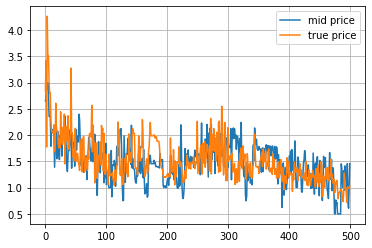

In [24]:
plt.plot(np.arange(500), average_fill_prices[10:,4]-mid_prices[10:])
plt.plot(np.arange(500), average_fill_prices[10:,4]-true_prices[10:])
plt.grid()
plt.legend(['mid price', 'true price'])

mid price


Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

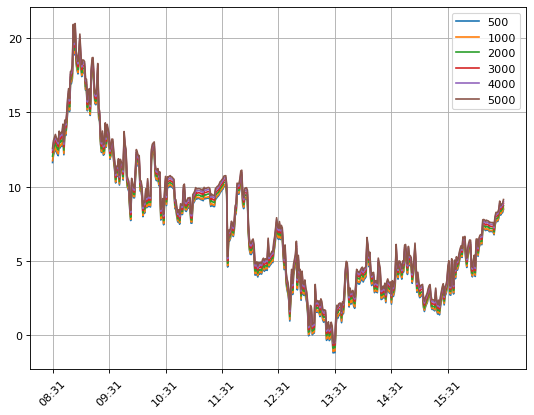

In [25]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
mid_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    mid_prices[i%510] += get_mid_price(bid_and_ask_through_day[i])
    curr_mid_price =  get_mid_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_mid_price)
for i in range(510):
    mid_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
mid_prices = apply_moving_average(np.copy(mid_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

true price

Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill an order 3000
Unable to fill an order 4000
Unable to fill an order 5000
Unable to fill

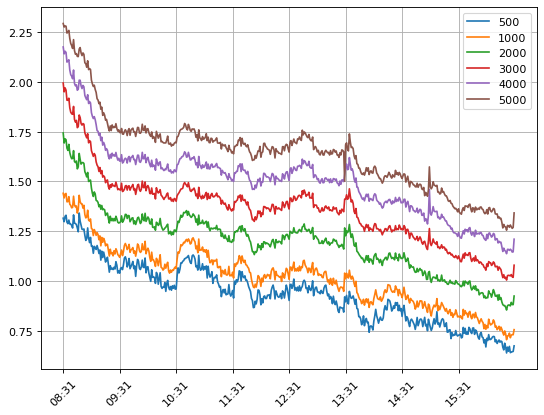

In [26]:
figure(figsize=(8, 6), dpi=80)
bid_and_ask_through_day = data[98]
order_sizes = [500, 1000, 2000, 3000, 4000, 5000]
true_prices = np.zeros(510)
average_fill_prices = np.zeros(shape = (510, 6))
for i in range(5100):
    true_prices[i%510] += get_true_price(bid_and_ask_through_day[i])
    curr_true_price =  get_true_price(bid_and_ask_through_day[i])
    for j in range(6):
        average_fill_prices[i%510][j] += get_sweep_to_fill_price(bid_and_ask_through_day[i], order_sizes[j],curr_true_price)
for i in range(510):
    true_prices[i]/=10
    average_fill_prices[i]/=10
#print(average_fill_prices[:,0])
true_prices = apply_moving_average(np.copy(true_prices), 5)
for i in range(6):
    average_fill_prices[:,i] = apply_moving_average(np.copy(average_fill_prices[:,i]), 5)
#average_fill_prices = apply_moving_average(np.copy(average_fill_prices), 3)

plot_since=30
for i in np.arange(len(order_sizes)):
    plt.plot(np.arange(510-plot_since), average_fill_prices[plot_since:,i]-true_prices[plot_since:])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x+plot_since)) for x in np.arange(510-plot_since, step=60)])
plt.xticks(ticks=np.arange(510-plot_since, step=60), labels=x_axis, rotation=45)
plt.grid()
plt.legend( order_sizes)

In [27]:
bid_and_ask_through_day[0]

array([[[1582., 1580., 1579., 1576., 1575.],
        [1377.,  500., 1044., 8009.,  766.]],

       [[1588., 1589., 1591., 1592., 1596.],
        [1149.,   53., 1036.,  500., 4222.]]])

In [28]:
order_inbalance_one_day=get_order_inbalance(data[0][:510])

Plotting Bid, ask and true market prices(exhibit 6)

In [29]:
mid_price_one_day=np.zeros(510)
true_price_one_day=np.zeros(510)

for i in range (0,510):
    mid_price_one_day[i]=get_mid_price(data[0][i])
    true_price_one_day[i]=get_true_price(data[0][i])

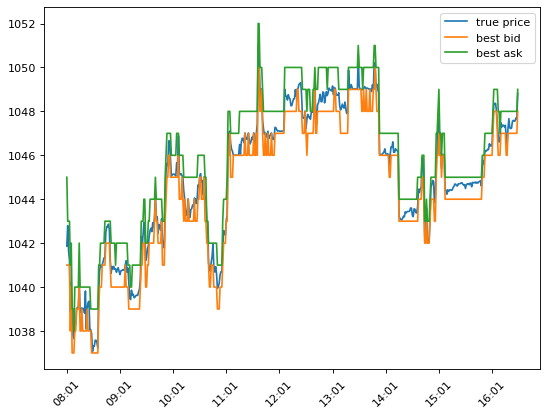

In [30]:
figure(figsize=(8, 6), dpi=80)

#plt.plot(np.arange(510), order_inbalance_one_day)#, mid_price_one_day)

#plt.plot(np.arange(510),  mid_price_one_day)
plt.plot(np.arange(510),  true_price_one_day)
plt.plot(np.arange(510),  data[0,:510,0,0,0])
plt.plot(np.arange(510),  data[0,:510,1,0,0])
x_axis=np.asarray([time_tuple_to_hr_mn_str(index_to_time(x)) for x in np.arange(510, step=60)])
plt.xticks(ticks=np.arange(510, step=60), labels=x_axis, rotation=45)
plt.legend(['true price', 'best bid', 'best ask'])

Plotting Sweep to Fill Costs vs Order Size (exhibit 8 and 9)?????

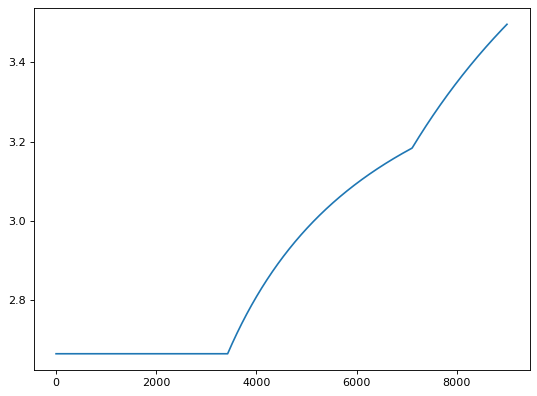

In [31]:
figure(figsize=(8, 6), dpi=80)
#bid_and_ask_through_first_two_hours = data[80][:120]
order_sizes_limit = 9000
true_price = get_true_price(data[80][40])
average_fill_prices = np.zeros(shape = (order_sizes_limit))
for i in range(1,order_sizes_limit+1):
    average_fill_prices[i-1] = get_sweep_to_fill_price(data[80][40], i,true_price)
plt.plot(average_fill_prices-true_price)

In [32]:
data[80][40]

array([[[1640., 1639., 1638., 1637., 1636.],
        [1715., 5727., 2576., 2830., 5163.]],

       [[1644., 1645., 1646., 1647., 1648.],
        [3425., 3681., 4334., 2581., 4997.]]])

In [33]:
order_inbalance_10_days=get_order_inbalance(data[1])
mid_price_10_days=[get_mid_price(data[1][i]) for i in range (0, 5100)]

In [34]:
company=90
order_inbalance_10_days=[round(i, 1) for i in get_order_inbalance(data[company])]
mid_price_10_days=np.asarray([get_mid_price(data[company][i]) for i in range (5100)])
price_diff=mid_price_10_days[:5099]-mid_price_10_days[1:]
inbalance_averageprice={}
for i in range(len(price_diff)):
    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    else:
        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
for k in inbalance_averageprice.keys():
    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

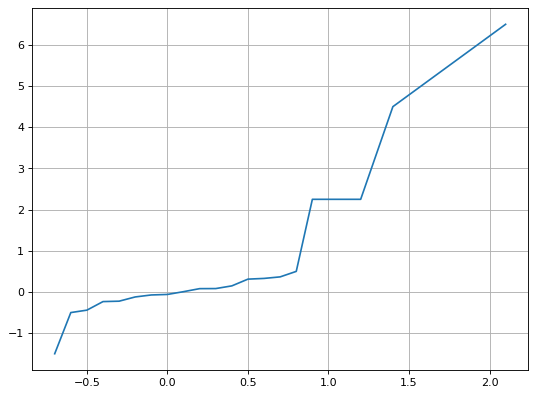

In [35]:
inbalance_averageprice_array=np.sort( np.asarray([[k, v] for k,v in inbalance_averageprice.items()]), axis=0)
figure(figsize=(8, 6), dpi=80)

plt.plot(inbalance_averageprice_array[5:,0], inbalance_averageprice_array[5:,1])

plt.grid()

In [36]:
inbalance_averageprice_array.shape

(25, 2)

Exhibit 17 -> Market impact for E-mini S&P Futures on a Typical Day (how to calculate true price after market impact???)

Unable to fill an order 5000
Unable to fill an order 2500
Unable to fill an order 5000
Unable to fill an order 5000


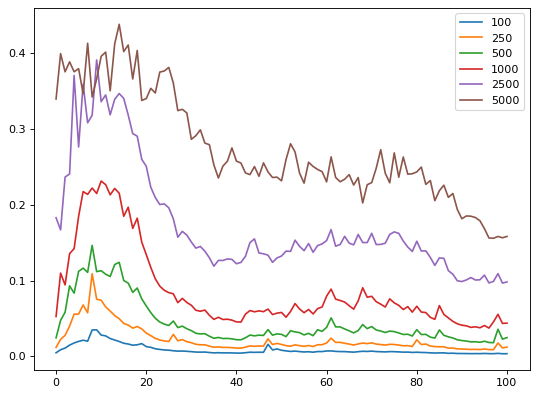

In [37]:
company_id = 15
order_sizes = [100, 250, 500, 1000, 2500, 5000]
num_of_timestamps = int((5100/5)-1)
modulo = int(510/5-1)
differences_in_prices = np.zeros(shape = (modulo, 6))
for i in range(num_of_timestamps):
    for order_size_ind in range(len(order_sizes)):
        price_before = get_true_price(np.copy(data[company_id][i*5]))
        price_after = get_true_price_after_sweep_to_fill(np.copy(data[company_id][i*5]), order_sizes[order_size_ind], price_before)
        differences_in_prices[i%modulo][order_size_ind] += abs(price_after - price_before)
figure(figsize=(8, 6), dpi=80)
for i in range(modulo):
    differences_in_prices[i]/=10
for k in range(len(order_sizes)):
    plt.plot(np.arange(modulo), apply_moving_average(np.copy(differences_in_prices[:,k]), 3))
plt.legend( order_sizes)
    

# Exhibit 3&4


In [38]:
comp_id=1
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
order_inbalance_comp=np.empty(shape=order_book_comp.shape[:2])
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]
    order_inbalance_comp[i]=get_order_inbalance(order_book_comp[i])

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time
time_to_next_trade=np.empty(shape=order_inbalance_comp.shape)

In [39]:
time_to_next_trade.shape

(10, 510)

In [40]:
trades[0].shape

(10,)

In [41]:
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        #print("XD", book_counter)
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        trade_time_tuple=trades_time_comp[day][trade_counter][2]
        time_to_next_trade[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])-timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
        # time to next trade given in seconds


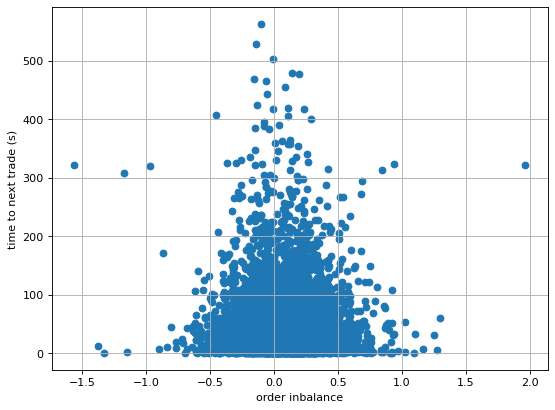

In [42]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='order inbalance', ylabel='time to next trade (s)')
plt.scatter(order_inbalance_comp.flatten(), time_to_next_trade.flatten())
plt.grid()
plt.show()

In [43]:
next_trades_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(time_to_next_trade.shape[0]):
    trade_counter=0
    for book_counter in range(time_to_next_trade.shape[1]):
        time_tuple=index_to_time(book_counter)
        while time_tuple>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        next_trade_price=trades_time_comp[day][trade_counter][0]
        next_trades_prices[day, book_counter]=next_trade_price
        # time to next trade given in seconds

In [44]:
mid_market_prices=np.empty(shape=order_inbalance_comp.shape)
for day in range(order_book_comp.shape[0]):
    for record in range(order_book_comp.shape[1]):
        mid_market_prices[day, record]=get_mid_price(order_book_comp[day, record])

In [45]:
for day in range(mid_market_prices.shape[0]):
    for record in range(mid_market_prices.shape[1]):
        if mid_market_prices[day,record]==0:
            print(day, record)

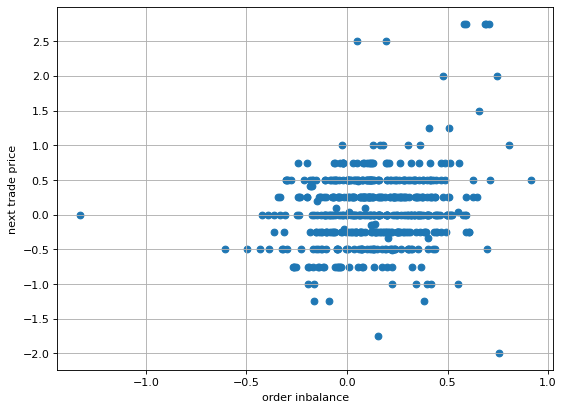

In [46]:
figure(figsize=(8, 6), dpi=80)
day=5
plt.axes(xlabel='order inbalance', ylabel='next trade price')
plt.scatter(order_inbalance_comp[day].flatten(), (next_trades_prices-mid_market_prices)[day].flatten())
max_next_trade_price=max((next_trades_prices-mid_market_prices)[day].flatten())
min_next_trade_price=min((next_trades_prices-mid_market_prices)[day].flatten())
plt.yticks(ticks=np.arange(start=min_next_trade_price, stop=max_next_trade_price, step=0.5))
plt.grid()
plt.show()

# Exhibit 11&12


In [47]:
interval=1
comp_id=3
order_book_comp=np.empty(shape=(10, 510, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
    order_book_comp[i]=data[comp_id, 510*i:510*(i+1)]

trades_time_comp=np.copy(trades[comp_id])
for day in trades_time_comp:
    day.sort(key=lambda hour: hour[2]) # sort by trade time

timestamps=510//interval
# buys on even, sells on odd
vwaps=np.zeros(shape=(10,2*timestamps)) 
order_sizes=np.zeros(shape=(10,2*timestamps))
#vwaps_sells=np.zeros(shape=(10,timestamps))
#order_sizes_sells=np.zeros(shape=(10,timestamps))



In [48]:
empty_orders=0
for day in range(vwaps.shape[0]):
    trade_counter=0
    for counter in range(vwaps.shape[1]//2):
        true_price=get_true_price(order_book_comp[day,counter])
        time_tuple=index_to_time(interval*(counter+1))
        buys=[]
        sells=[]
        buys_weights=[]
        sells_weights=[]
        while time_tuple>trades_time_comp[day][trade_counter][2]:
            if true_price<trades_time_comp[day][trade_counter][0]:
                buys.append(trades_time_comp[day][trade_counter][0])
                buys_weights.append(trades_time_comp[day][trade_counter][1])
            else:
                sells.append(trades_time_comp[day][trade_counter][0])
                sells_weights.append(trades_time_comp[day][trade_counter][1])               
            trade_counter+=1
            
        # in case there were no sells or buys during the interval            
        try:
            buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
        except:
            buys_avg=true_price
            buys_vol=0
            empty_orders+=1
        try:
            sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
        except:
            sells_avg=true_price
            sells_vol=0
            empty_orders+=1
        if sells_vol>10000 or buys_vol>10000:
            continue 
        vwaps[day,2*counter]=buys_avg-true_price
        vwaps[day,2*counter +1]=true_price-sells_avg
        order_sizes[day,2*counter]=buys_vol
        order_sizes[day,2*counter +1]=sells_vol
print('{}% of intervals were empty'.format(100*empty_orders/(10*2*timestamps)))

64.42156862745098% of intervals were empty


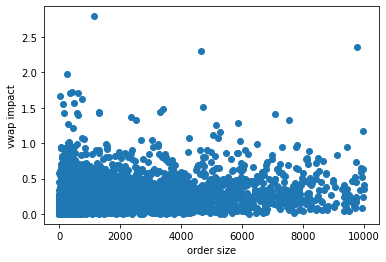

In [49]:
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes.flatten(), vwaps.flatten())

In [50]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#np.unique(stacked_vwaps_sizes, return_counts=True)

In [51]:
np.sort(np.array([[1,2],[1,4],[1,3]]), axis=0)

array([[1, 2],
       [1, 3],
       [1, 4]])

In [52]:
stacked_vwaps_sizes=np.stack((vwaps.flatten(), order_sizes.flatten()), axis=-1)
stacked_vwaps_sizes=np.sort(stacked_vwaps_sizes, axis=0)
#for x in  stacked_vwaps_sizes:#[:,0]
 #   if x[0]:
  #      print(x)

In [53]:
np.unique(order_sizes, return_counts=True)[1][0]

7060

In [54]:
np.unique(vwaps, return_counts=True)[1][0]

7060

In [55]:
vwaps[0].shape

(1020,)

**Exhibit 15 & 16**

In [56]:
company_id = 0
how_many_days = trades[company_id].shape[0]
num_of_five_min_buck = (7*60+2*30)//5
trading_volume_in_buckets = np.zeros(num_of_five_min_buck)
open_hour = 8
open_min = 30
end_hour = 16
end_min = 30
min_prices_in_buckets = np.ones(num_of_five_min_buck) * 10000000.0
max_prices_in_buckets = np.zeros(num_of_five_min_buck)

In [57]:
for i in range(10): #for every day
    for trade in trades[company_id][i]:
        trade_time = trade[2]
        trade_hour = trade_time[0]
        trade_min = trade_time[1]
        if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
            #print(trade)
            #print(trade_hour<open_hour)
            #print(trade_hour==open_hour and trade_min<open_min)
            #print(trade_hour==end_hour and trade_min>end_min)
            #print(trade_hour)
            #print(end_hour)
            #print(trade_hour>end_hour)
            continue
        which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//5
        min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
        max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
        trading_volume_in_buckets[which_bucket] += trade[1]
trading_volume_in_buckets/=10 #we take average of all days

In [58]:
price_volatility_in_buckets = max_prices_in_buckets - min_prices_in_buckets

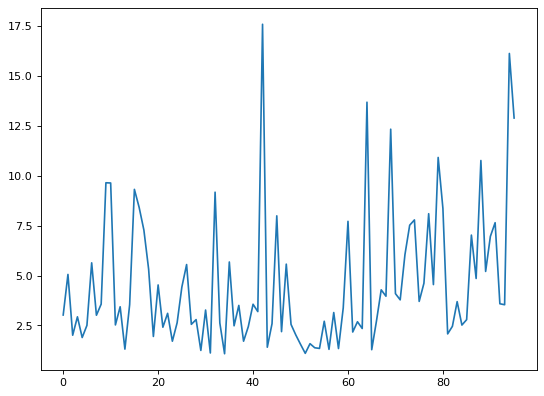

In [59]:
figure(figsize=(8, 6), dpi=80)

plt.plot(trading_volume_in_buckets/1000)

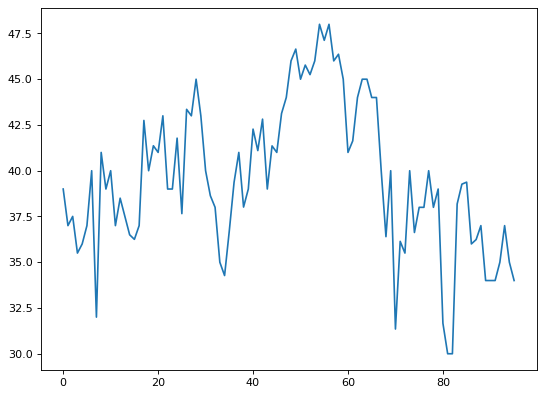

In [60]:
figure(figsize=(8, 6), dpi=80)
plt.plot(price_volatility_in_buckets)

# plot ORDER_IMPACT & VWAP


In [61]:
def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]
    result=np.zeros(timestamps//interval)
    for i in range (0,timestamps//interval):
        for j in range(interval):
            result[i]+=math.log((1e-10+np.sum(record[i+j][0][1]))/(1e-10+np.sum(record[i+j][1][1]))) # ln(bid size/ask size)
    return result

In [62]:
def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [63]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(vwaps.shape[0]):
        trade_counter=0
        for counter in range(vwaps.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(interval*(counter+1))
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
                sells_vol=math.nan
            if buys_vol>max_vol:
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return vwaps, order_sizes

In [64]:
np.average(np.arange(start=0, stop=11), weights=np.arange(11), returned=True)

(7.0, 55.0)

22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


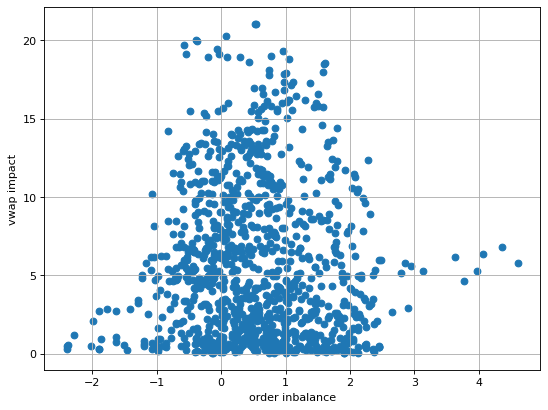

In [65]:
company=1
interval=5
time_to_skip=30
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)
order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='vwap impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
plt.grid()


In [66]:
order_inbalance.shape


(10, 96)

#  NEXTORDERX & S2FIMPACT

In [67]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(book_counter*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=np.abs(next_trade_price-true_price) #abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError
    return next_trade_x

In [68]:
order_book_comp=np.empty(shape=(10, 510-30, 2, 2, 5))
for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[0, 510*i+30:510*(i+1)]
get_true_price(order_book_comp[1, 4])

1044.0542079729794

In [69]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 5))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(interval*(counter+1))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError:
                buys_s2f_price=true_price
                buys_vol=0
                empty_buys+=1
                s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError:
                sells_s2f_price=true_price
                sells_vol=0
                empty_sells+=1
                s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [70]:
get_sweep_to_fill_price(data[0, 965], 40137, get_true_price(data[0, 965]), sweep_buys=False)

1051.0469392331265

In [71]:
get_true_price(data[0, 965])

1048.9780872414447

In [72]:
data[0, 965]

array([[[ 1048.,  1047.,  1046.,  1045.,  1044.],
        [ 9552., 16964., 14256.,  8836., 11223.]],

       [[ 1050.,  1051.,  1052.,  1053.,  1054.],
        [ 9980., 18293., 14908.,  7544., 12958.]]])

21.515151515151516% of intervals were SELL empty
27.828282828282827% of intervals were BUY empty
20.606060606060606% of intervals were SELL empty
26.565656565656564% of intervals were BUY empty


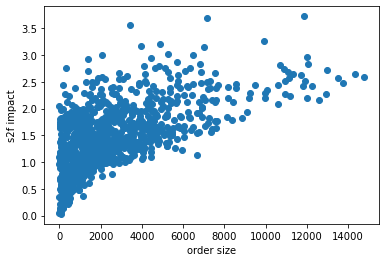

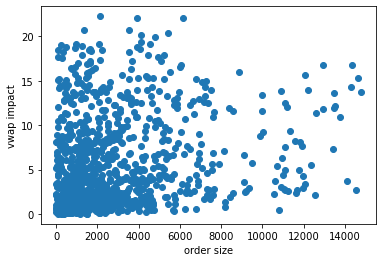

In [73]:
company_id=98
interval=5
time_to_skip=15

s2f_impacts, order_sizes_s2f=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwaps, order_sizes_vwaps=get_vwap_and_ordersizes_comp(company_id, interval, time_to_skip, max_vol=np.max(order_sizes_s2f.flatten()))

plt.axes(xlabel='order size', ylabel='s2f impact')
plt.scatter(order_sizes_s2f.flatten(), s2f_impacts.flatten())
plt.show()
plt.axes(xlabel='order size', ylabel='vwap impact')
plt.scatter(order_sizes_vwaps.flatten(), vwaps.flatten())
plt.show()

22.8125% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty


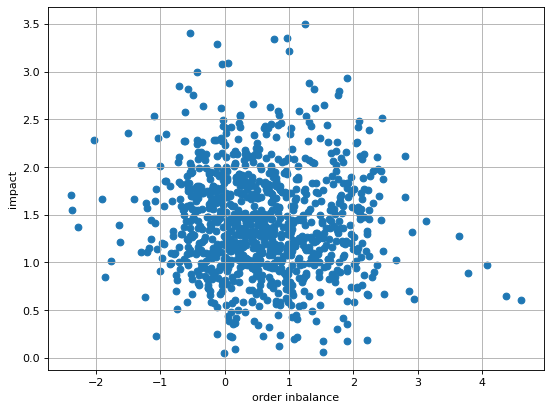

In [74]:
company=1
interval=5
time_to_skip=30
s2f_impacts, _=get_s2f_impact_and_ordersizes_comp(company_id, interval, time_to_skip,)
vwap, _=get_vwap_and_ordersizes_comp(company, interval, time_to_skip, use_abs=True)

order_inbalance=get_order_inbalance_comp(company, interval, time_to_skip)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='order inbalance', ylabel='impact')
plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), s2f_impacts)
#plt.scatter(np.repeat(order_inbalance, repeats=2, axis=1), vwap)
#plt.legend(['s2f', 'vwap'])
plt.grid()

# TRUE&MID PRICE


In [75]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp
def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [76]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [77]:
get_price_change_comp(interval=5, time_to_skip=30).shape

(10, 96)

In [78]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('zly shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

# HEATMAP

In [79]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,30,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [80]:
def get_trading_volume_and_price_volatility_bula(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (8*60+30-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    open_hour = 8
    open_min = 0
    end_hour = 16
    end_min = 30
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 10000000.0
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            trade_hour = trade_time[0]
            trade_min = trade_time[1]
            if (trade_hour<open_hour) or (trade_hour==open_hour and trade_min<open_min) or (trade_hour==end_hour and trade_min>end_min) or trade_hour>end_hour:
                continue
            which_bucket = ((trade_hour-open_hour)*60 + (trade_min-open_min))//interval
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [81]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


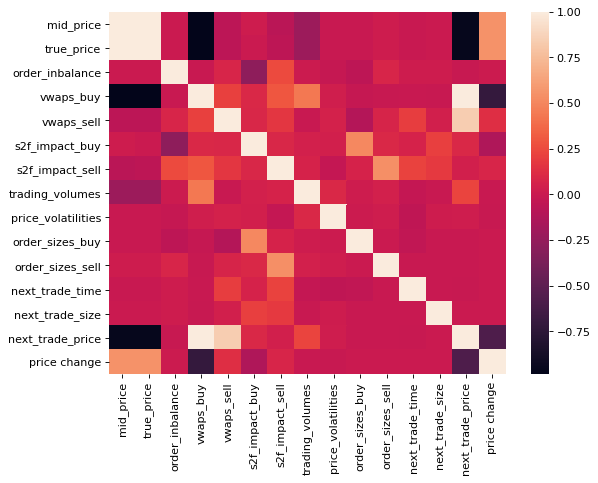

In [82]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='pearson'))
plt.show()

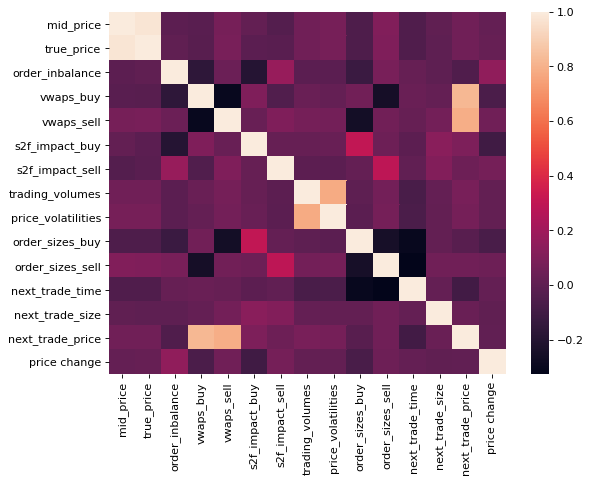

In [83]:
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

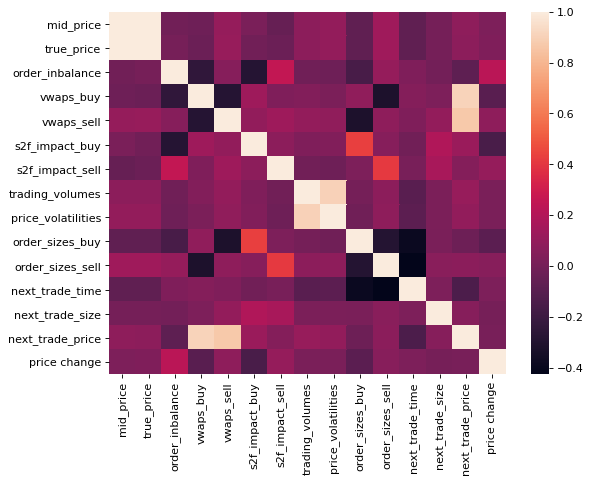

In [84]:
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(df.corr(method='spearman'))
plt.show()

# REGRESSION LOGISTIC

In [85]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures


In [86]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
    rolled_records = np.roll(records, past, axis = 1)
    rolled_records = rolled_records[:,past:]
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            elements_in_past = np.copy(records[day][buck:buck+past])
            count_elem = 0.0
            sum_elem = 0.0
            for i in range(len(elements_in_past)):
                if math.isnan(elements_in_past[i]):
                    elements_in_past[i] = 0
                else:
                    sum_elem+=elements_in_past[i]
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [160]:
average_smoothing(np.arange(start=1, stop=101).reshape(10,10), 2)

array([[ 1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5],
       [11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5],
       [21.5, 22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5],
       [31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5],
       [41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5],
       [51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5],
       [61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5],
       [71.5, 72.5, 73.5, 74.5, 75.5, 76.5, 77.5, 78.5],
       [81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5, 88.5],
       [91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5]])

In [157]:
np.arange(start=1, stop=101).reshape(10,10)

array([[  1,   2,   3,   4,   5,   6,   7,   8,   9,  10],
       [ 11,  12,  13,  14,  15,  16,  17,  18,  19,  20],
       [ 21,  22,  23,  24,  25,  26,  27,  28,  29,  30],
       [ 31,  32,  33,  34,  35,  36,  37,  38,  39,  40],
       [ 41,  42,  43,  44,  45,  46,  47,  48,  49,  50],
       [ 51,  52,  53,  54,  55,  56,  57,  58,  59,  60],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  70],
       [ 71,  72,  73,  74,  75,  76,  77,  78,  79,  80],
       [ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90],
       [ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100]])

In [87]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
#trading_volumes_bula, price_volatilities_bula = get_trading_volume_and_price_volatility_bula(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
(10, 480)
(10, 480)
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


In [88]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [89]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [90]:
def get_y_to_test_max(true_prices, period_of_getting_max, interval_in_data):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.zeros(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            if j<(num_of_averaged_minutes-next_indices):
                res[i][j] = np.max(true_prices[i][j:j+next_indices])
            else:
                res[i][j] = np.max(true_prices[i][j:])
    return res
def get_y_to_test_min(true_prices, period_of_getting_min, interval_in_data):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.zeros(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            if j<(num_of_averaged_minutes-next_indices):
                res[i][j] = np.min(true_prices[i][j:j+next_indices])
            else:
                res[i][j] = np.min(true_prices[i][j:])
    return res

In [187]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            if (max_val-true_prices[i,j])/true_prices[i,j]>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=10e-7):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [92]:
np.arange(9).reshape((3, 3))
np.abs(-3)

3

In [93]:
def get_X_y(comp_id=1, interval=5, time_to_skip=0, time_back=1):
    mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
    true_price = get_true_price_comp(comp_id, interval, time_to_skip)
    order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
    vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
    vwaps_buy = vwaps[:,::2]
    vwaps_sell = vwaps[:,1::2]
    s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
    s2f_impact_buy = s2f_impact[:,::2]
    s2f_impact_sell = s2f_impact[:,1::2]
    order_sizes_buy = order_sizes[:,::2]
    order_sizes_sell = order_sizes[:,1::2]
    trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
    next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
    next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
    next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
    price_change=get_price_change_given_prices(true_price)
    price_change_up_down=np.vectorize(up_down_bool)(price_change)

    X=np.array([
   average_smoothing(order_inbalance, time_back).flatten(), 
   average_smoothing(vwaps_buy, time_back).flatten(), 
   average_smoothing(vwaps_sell, time_back).flatten(), 
   average_smoothing(s2f_impact_buy, time_back).flatten(), 
   average_smoothing(s2f_impact_buy, time_back).flatten(), 
   average_smoothing(trading_volumes, time_back).flatten(), 
   average_smoothing(price_volatilities, time_back).flatten(), 
   average_smoothing(order_sizes_buy, time_back).flatten(), 
   average_smoothing(order_sizes_sell, time_back).flatten(), 
   average_smoothing(next_trade_time, time_back).flatten(), 
   average_smoothing(next_trade_size, time_back).flatten(), 
   average_smoothing(next_trade_price, time_back).flatten(), 
   average_smoothing(order_inbalance, time_back).flatten(), 
 #  average_smoothing(price_change, time_back).flatten(), 
    
            ]).T
    
    y=price_change_up_down[:,time_back:].flatten()

    return X, y

In [94]:

comp_id = 3
interval=1
time_to_skip=30
time_back=1


names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'order_sizes_buy', 
    'order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
  #  'price change'
      ]

X,y=get_X_y(comp_id, interval, time_to_skip, time_back)
split=int(y.size*0.8)
#clf = LinearRegression().fit(X[:split], y[:split])
clf = LogisticRegression().fit(X[:split], y[:split])
y_predicted=clf.predict(X[split:])

for i in range(len(names)):
    print(names[i], " ", clf.coef_[0,i])
#print(clf.coef_)
#print('mse', mse(y[split:], y_predicted))
clf.score(X[split:], y[split:])

33.052083333333336% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
33.197916666666664% of intervals were SELL empty
36.270833333333336% of intervals were BUY empty
order_inbalance   -6.202629882307405e-10
vwaps_buy   1.5890028017888606e-09
vwaps_sell   -7.531015929799861e-10
s2f_impact_buy   1.1840969987025607e-09
s2f_impact_sell   1.1840969987025607e-09
trading_volumes   -5.941822671528862e-07
price_volatilities   7.977762681516395e-09
order_sizes_buy   8.008103722966009e-06
order_sizes_sell   8.968447056388324e-06
next_trade_time   2.721204428359965e-07
next_trade_size   3.143248531330452e-07
next_trade_price   -8.669013767717956e-10


0.5187891440501043

In [95]:
clf.coef_.flatten()

array([-6.20262988e-10,  1.58900280e-09, -7.53101593e-10,  1.18409700e-09,
        1.18409700e-09, -5.94182267e-07,  7.97776268e-09,  8.00810372e-06,
        8.96844706e-06,  2.72120443e-07,  3.14324853e-07, -8.66901377e-10,
       -6.20262988e-10])

# Polynomials

In [96]:
poly_features = PolynomialFeatures(3).fit_transform(X)

clf = LogisticRegression().fit(poly_features[:split], y[:split])
y_predicted=clf.predict(poly_features[split:])

    
#print('mse', mse(y[split:], y_predicted))
clf.score(poly_features[split:], y[split:])

0.48747390396659707

# Testing predictions

In [97]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier



In [98]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [126]:
def get_X_y_classic(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                    y_name='true_price', 
                    check='change',
                    swing_interval=30): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    #X = np.array(X)
    #X = X.T
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        price_change=functions_to_call['price_change'](y)    
        y = price_change[:,time_back:].flatten()
    elif check=='swing_max':
       # get_y_to_test_max_bool(y, period_of_getting_max=60, interval, threshold=10e-7)
        pass
    elif check=='swing_min':
        pass
    else:
        y = y[:,time_back:].flatten()
      #  raise ValueError('bad check argument')
    
    return X, y

In [161]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)))
    #average_smoothing reduces shape "time_back" times per day
    index=0
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        X[:,index]=average_smoothing(arr, time_back).flatten()
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = y[:,time_back:].flatten()
    return y

In [139]:
1e-5+1

1.00001

In [115]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'trading_volumes':
            arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'price_volatilities':
            _, arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
            
        elif name in ['vwaps_buy', 's2f_impact_buy']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_sell', 's2f_impact_sell']:
            full_arr, _ = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        elif name in ['vwaps_order_sizes_buy', 's2f_order_sizes_buy']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,::2]
        elif name in ['vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
            _, full_arr = functions_to_call[name](comp_id, interval, time_to_skip)
            arr = full_arr[:,1::2]
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [116]:
'''
TODO
        #USE REGEX TO CHECK IF STATEMENT
        elif name in ['vwaps_buy', 's2f_impact_buy',   
                      'vwaps_sell', 's2f_impact_sell', 
                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',
                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:
'''

"\nTODO\n        #USE REGEX TO CHECK IF STATEMENT\n        elif name in ['vwaps_buy', 's2f_impact_buy',   \n                      'vwaps_sell', 's2f_impact_sell', \n                      'vwaps_order_sizes_buy', 's2f_order_sizes_buy',\n                      'vwaps_order_sizes_sell', 's2f_order_sizes_sell']:\n"

In [117]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [118]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [144]:
def test_logistic_regr_classic(X, y, split_percent, epsilon=1e-6, comp_id=1, 
                               use_scaling=True, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), LogisticRegression(max_iter=1000)).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=1000).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [120]:
def test_decision_tree_classic(X, y, split_percent, epsilon, comp_id,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("decision tree score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])

In [123]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.000001
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
print(average_comp_price[comp_id])
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check='change')
test_decision_tree_classic(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names)

851.5588014785882
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
Coefficient impact:
order_inbalance   0.08960681991177212
vwaps_buy   0.07032222857725065
vwaps_sell   0.02797476494834474
s2f_impact_buy   0.03098697629709517
s2f_impact_sell   0.05495836125556508
trading_volumes   0.12091588592759304
price_volatili

0.5736842105263158

In [118]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(0.0,10e-3, 10e-5)
scores=[]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names)
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comp_id, False))
#BEFORE SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty

Epsilon =  0.0
Coefficient impact:
order_inbalance   1.064938588841333e-09
vwaps_buy   -1.4375636459924213e-09
vwaps_sell   -2.6104721407207344e-10
s2f_impact_buy   8.031266954035321e-10
s2f_impact_sell   -1.024007208641128e-10
trading_volumes   4.2048856067413647e-0

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -1.1493620592236415e-07
vwaps_buy   -5.494284903002905e-07
vwaps_sell   -3.8267529888256177e-07
s2f_impact_buy   -9.73232117782996e-08
s2f_impact_sell   -7.178284115878729e-08
trading_volumes   -2.0583442309136655e-07
price_volatilities   2.236464310259567e-08
vwaps_order_sizes_buy   -1.5353534086386985e-06
vwaps_order_sizes_sell   -5.673067522643883e-06
s2f_order_sizes_buy   -9.145376789289478e-06
s2f_order_sizes_sell   -1.276655891126618e-06
next_trade_time   -4.957172595305387e-05
next_trade_size   -9.397092735051572e-05
next_trade_price   -1.0611487266220886e-06

Epsilon =  0.0005


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -4.910872188152737e-07
vwaps_buy   -2.4103680589083787e-06
vwaps_sell   -2.2709305221942023e-06
s2f_impact_buy   -4.4843870439763344e-07
s2f_impact_sell   -3.906392636248603e-07
trading_volumes   -1.3682988863244925e-06
price_volatilities   4.6793461107462354e-09
vwaps_order_sizes_buy   -1.913294417204886e-06
vwaps_order_sizes_sell   -4.400573927806944e-06
s2f_order_sizes_buy   -1.438504753938192e-05
s2f_order_sizes_sell   -3.548035963983885e-06
next_trade_time   -0.00016326636553086344
next_trade_size   -8.198138794627923e-05
next_trade_price   -5.381091418677318e-06

Epsilon =  0.0006000000000000001


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -3.014702249679635e-07
vwaps_buy   -1.42458713686126e-06
vwaps_sell   -1.0393656038499692e-06
s2f_impact_buy   -2.384550609640177e-07
s2f_impact_sell   -1.8331064172365753e-07
trading_volumes   -1.6798054052821037e-06
price_volatilities   -1.1597198208758739e-09
vwaps_order_sizes_buy   -2.048825298306286e-06
vwaps_order_sizes_sell   -3.004690587797027e-06
s2f_order_sizes_buy   -1.2545185761795768e-05
s2f_order_sizes_sell   -1.1890020753318499e-05
next_trade_time   -7.725715465356357e-05
next_trade_size   -0.00022560618839348898
next_trade_price   -2.667912115812878e-06

Epsilon =  0.0007


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -8.285232538191099e-07
vwaps_buy   -4.035551842017064e-06
vwaps_sell   -1.939829577247315e-06
s2f_impact_buy   -5.794655052886242e-07
s2f_impact_sell   -2.8965121905513743e-07
trading_volumes   -2.23076800625184e-06
price_volatilities   3.514702006199817e-08
vwaps_order_sizes_buy   -1.8770246804656205e-06
vwaps_order_sizes_sell   -4.029551250122723e-06
s2f_order_sizes_buy   -1.3795760960832455e-05
s2f_order_sizes_sell   -2.5652386131977e-05
next_trade_time   -0.00013903480425188838
next_trade_size   -0.00018542589058175707
next_trade_price   -6.5449702297974336e-06

Epsilon =  0.0008


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -5.126629047905715e-07
vwaps_buy   -2.802094377494403e-06
vwaps_sell   -1.5525042381250041e-06
s2f_impact_buy   -3.5377627114303857e-07
s2f_impact_sell   -2.424478864057369e-07
trading_volumes   -1.7445294326902732e-06
price_volatilities   3.6791737760544546e-08
vwaps_order_sizes_buy   -1.1485301294267197e-05
vwaps_order_sizes_sell   -3.3412686564352207e-06
s2f_order_sizes_buy   -8.089033150927202e-06
s2f_order_sizes_sell   -1.4510243259496524e-05
next_trade_time   -0.00010332392053466271
next_trade_size   -0.00041862034603316265
next_trade_price   -5.01470071721643e-06

Epsilon =  0.0009000000000000001


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -1.1804836760850023e-06
vwaps_buy   -4.866702269127511e-06
vwaps_sell   -3.9270460597897805e-06
s2f_impact_buy   -5.677839189782723e-07
s2f_impact_sell   -6.223434275652693e-07
trading_volumes   -1.39631915287677e-06
price_volatilities   7.480412475482736e-08
vwaps_order_sizes_buy   -1.089879839200873e-05
vwaps_order_sizes_sell   -2.4689385797751415e-06
s2f_order_sizes_buy   -7.886311958678659e-06
s2f_order_sizes_sell   -1.261536636530791e-05
next_trade_time   -0.0002173059932725282
next_trade_size   -0.0006352606964442722
next_trade_price   -9.904968807163386e-06

Epsilon =  0.001


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -2.6296496711204282e-06
vwaps_buy   -1.1097739064964844e-05
vwaps_sell   -9.122048279721184e-06
s2f_impact_buy   -1.357559826480253e-06
s2f_impact_sell   -1.3510593067659993e-06
trading_volumes   -1.0289630595357851e-06
price_volatilities   -0.00014380723217640584
vwaps_order_sizes_buy   -1.76741813036351e-06
vwaps_order_sizes_sell   -1.9190866627832514e-06
s2f_order_sizes_buy   -1.570078936900115e-05
s2f_order_sizes_sell   -1.2431487149009717e-05
next_trade_time   -0.0006788243180589836
next_trade_size   -0.0008790919772710299
next_trade_price   -2.3634311340011522e-05

Epsilon =  0.0011


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.011529531302361656
vwaps_buy   -0.04700150590778976
vwaps_sell   -0.03331473346973332
s2f_impact_buy   -0.005609227769194103
s2f_impact_sell   -0.005735403332206327
trading_volumes   -5.563370206262317e-07
price_volatilities   0.029707986974809555
vwaps_order_sizes_buy   -2.774185681861043e-07
vwaps_order_sizes_sell   -3.6395982163065327e-07
s2f_order_sizes_buy   -3.950743035101403e-06
s2f_order_sizes_sell   -1.575153646314022e-05
next_trade_time   -0.0003840634404235015
next_trade_size   -0.0004279082309217307
next_trade_price   -0.09253760594309424

Epsilon =  0.0012000000000000001


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.012612501023105752
vwaps_buy   -0.054326382493346086
vwaps_sell   -0.033714954903891495
s2f_impact_buy   -0.006371669444874224
s2f_impact_sell   -0.005479555541112261
trading_volumes   -2.702737960294545e-06
price_volatilities   0.038235638664605366
vwaps_order_sizes_buy   -1.8130846937971283e-07
vwaps_order_sizes_sell   2.1797472895465892e-07
s2f_order_sizes_buy   -5.33221779377164e-07
s2f_order_sizes_sell   -1.9095020715548125e-05
next_trade_time   -0.00020385594245319748
next_trade_size   -0.0006360586694868912
next_trade_price   -0.10049228389179711

Epsilon =  0.0013000000000000002


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.008086413408509558
vwaps_buy   -0.04251479346116702
vwaps_sell   -0.03590561254954746
s2f_impact_buy   -0.00532056620407108
s2f_impact_sell   -0.005600082559323033
trading_volumes   -4.284991884793831e-06
price_volatilities   0.020117775340354565
vwaps_order_sizes_buy   8.896847398586274e-07
vwaps_order_sizes_sell   1.6104075346671459e-06
s2f_order_sizes_buy   -7.2464125408609505e-06
s2f_order_sizes_sell   -2.4052425765004954e-05
next_trade_time   -0.00028549412556271324
next_trade_size   -0.000734633000376446
next_trade_price   -0.09105492209222364

Epsilon =  0.0014


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.011827993396227768
vwaps_buy   -0.0620490983887628
vwaps_sell   -0.05728509344349424
s2f_impact_buy   -0.008899215807936492
s2f_impact_sell   -0.008300262861243874
trading_volumes   -4.205408773610329e-06
price_volatilities   0.02871126467437972
vwaps_order_sizes_buy   -2.228418273791447e-06
vwaps_order_sizes_sell   5.965599439010165e-07
s2f_order_sizes_buy   -7.68417200352795e-06
s2f_order_sizes_sell   -7.58112318302718e-06
next_trade_time   -6.743731514074939e-05
next_trade_size   -0.0008310774602806527
next_trade_price   -0.13909514379615853

Epsilon =  0.0015


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.009538776682682153
vwaps_buy   -0.06684765585203933
vwaps_sell   -0.05267411191516933
s2f_impact_buy   -0.00993100005050849
s2f_impact_sell   -0.0075787766967276606
trading_volumes   -3.0688117849139017e-06
price_volatilities   0.03361541382395781
vwaps_order_sizes_buy   -2.645725710258146e-06
vwaps_order_sizes_sell   5.288260545836918e-07
s2f_order_sizes_buy   -1.8477623867959215e-05
s2f_order_sizes_sell   -2.3015477893108413e-05
next_trade_time   -0.0009076240892309262
next_trade_size   -0.0006318513988303109
next_trade_price   -0.1309288472925058

Epsilon =  0.0016


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.007471276351644358
vwaps_buy   -0.04358586286454225
vwaps_sell   -0.04054303631243731
s2f_impact_buy   -0.00635132473005887
s2f_impact_sell   -0.0064229802356938
trading_volumes   2.753688626640336e-06
price_volatilities   0.031607368815531625
vwaps_order_sizes_buy   -0.0006509448481364851
vwaps_order_sizes_sell   -8.82478855537044e-07
s2f_order_sizes_buy   0.0005951899581787409
s2f_order_sizes_sell   -4.361447850373063e-05
next_trade_time   -0.0167070129205974
next_trade_size   0.00011677336439327117
next_trade_price   -0.08680333841536038

Epsilon =  0.0017000000000000001


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.0036515621938521267
vwaps_buy   -0.04120898560665802
vwaps_sell   -0.03655223979124355
s2f_impact_buy   -0.00624433434523282
s2f_impact_sell   -0.006761168997277137
trading_volumes   2.509561922226833e-06
price_volatilities   0.023687626639154313
vwaps_order_sizes_buy   -0.0017751126659972555
vwaps_order_sizes_sell   0.002549885467196578
s2f_order_sizes_buy   0.0016829355298195962
s2f_order_sizes_sell   -0.0025746398780859365
next_trade_time   -0.00983269285110217
next_trade_size   -0.00030000209227735075
next_trade_price   -0.08245250405093534

Epsilon =  0.0018000000000000002


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.004578195207855344
vwaps_buy   -0.05177523890708497
vwaps_sell   -0.046519139415151387
s2f_impact_buy   -0.007794886222749095
s2f_impact_sell   -0.008629522473629041
trading_volumes   2.9293938505280977e-06
price_volatilities   0.028644013182980876
vwaps_order_sizes_buy   -0.0005082371936408398
vwaps_order_sizes_sell   0.0005684614425069687
s2f_order_sizes_buy   0.0004238235792649906
s2f_order_sizes_sell   -0.0005878441310797979
next_trade_time   -0.010932323788638312
next_trade_size   -0.0001681795019629591
next_trade_price   -0.10370140375525484

Epsilon =  0.0019


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.003728748218075928
vwaps_buy   -0.04432467774265287
vwaps_sell   -0.04173550682502953
s2f_impact_buy   -0.006703098873217555
s2f_impact_sell   -0.0075947201174580885
trading_volumes   3.467537458331358e-06
price_volatilities   0.023213262036126555
vwaps_order_sizes_buy   -0.0007471483641800997
vwaps_order_sizes_sell   0.0004991980887950442
s2f_order_sizes_buy   0.0006679275424379319
s2f_order_sizes_sell   -0.0005172848193770591
next_trade_time   -0.012006056859947474
next_trade_size   -0.00034278413217637824
next_trade_price   -0.09135336067311095

Epsilon =  0.002


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.0035423447305826077
vwaps_buy   -0.05489601911251413
vwaps_sell   -0.0470082516590124
s2f_impact_buy   -0.008340932150939657
s2f_impact_sell   -0.0091204703388245
trading_volumes   2.54864657790208e-06
price_volatilities   0.022754616343009043
vwaps_order_sizes_buy   -0.0016789588589735014
vwaps_order_sizes_sell   0.0013247159000145084
s2f_order_sizes_buy   0.0016242125478118092
s2f_order_sizes_sell   -0.001335941699632628
next_trade_time   -0.01127520949151764
next_trade_size   -0.0004928009754374191
next_trade_price   -0.10690681808048808

Epsilon =  0.0021000000000000003


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002984430180792719
vwaps_buy   -0.04817179609424691
vwaps_sell   -0.04853071011529455
s2f_impact_buy   -0.007218641842531447
s2f_impact_sell   -0.008198276027127029
trading_volumes   2.4723877315149373e-07
price_volatilities   0.016395086514243498
vwaps_order_sizes_buy   -0.0017464566355870853
vwaps_order_sizes_sell   0.0002114761339454998
s2f_order_sizes_buy   0.0017152776757555694
s2f_order_sizes_sell   -0.0002328966800852778
next_trade_time   -0.005236745476204486
next_trade_size   -0.00045533670309402265
next_trade_price   -0.10008432334149367

Epsilon =  0.0022


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002466949443077794
vwaps_buy   -0.047306293887725746
vwaps_sell   -0.042771442094435445
s2f_impact_buy   -0.0068620216096368005
s2f_impact_sell   -0.008515231187839884
trading_volumes   -1.3442188139986213e-07
price_volatilities   0.018852460697755077
vwaps_order_sizes_buy   -0.00103827998160404
vwaps_order_sizes_sell   0.0001246791779820246
s2f_order_sizes_buy   0.0010297139158327328
s2f_order_sizes_sell   -6.371392268032713e-05
next_trade_time   -0.008608605407726793
next_trade_size   -0.0007119894510270535
next_trade_price   -0.09199299910243636

Epsilon =  0.0023


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002466949443077794
vwaps_buy   -0.047306293887725746
vwaps_sell   -0.042771442094435445
s2f_impact_buy   -0.0068620216096368005
s2f_impact_sell   -0.008515231187839884
trading_volumes   -1.3442188139986213e-07
price_volatilities   0.018852460697755077
vwaps_order_sizes_buy   -0.00103827998160404
vwaps_order_sizes_sell   0.0001246791779820246
s2f_order_sizes_buy   0.0010297139158327328
s2f_order_sizes_sell   -6.371392268032713e-05
next_trade_time   -0.008608605407726793
next_trade_size   -0.0007119894510270535
next_trade_price   -0.09199299910243636

Epsilon =  0.0024000000000000002


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.0026111543556075175
vwaps_buy   -0.0964478212407976
vwaps_sell   -0.08329873567046417
s2f_impact_buy   -0.013772497339078238
s2f_impact_sell   -0.017427039613591457
trading_volumes   -1.0390857900521586e-06
price_volatilities   0.03211576995270874
vwaps_order_sizes_buy   -0.001957154558048326
vwaps_order_sizes_sell   0.00019301741681733244
s2f_order_sizes_buy   0.0019684202910839194
s2f_order_sizes_sell   -0.00012460115969671582
next_trade_time   -0.009231157246223061
next_trade_size   -0.0007352575488059942
next_trade_price   -0.1842244511794626

Epsilon =  0.0025


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.0005683853011183693
vwaps_buy   -0.01823908068124835
vwaps_sell   -0.0158031190540805
s2f_impact_buy   -0.0026056517795669527
s2f_impact_sell   -0.003321554169162705
trading_volumes   3.6970038998475875e-06
price_volatilities   0.006397975150500203
vwaps_order_sizes_buy   -0.002006485125069936
vwaps_order_sizes_sell   0.00013508902730806566
s2f_order_sizes_buy   0.0020417140977729135
s2f_order_sizes_sell   -2.7379011140670915e-05
next_trade_time   -0.03794951074394975
next_trade_size   -0.0002702802146823893
next_trade_price   -0.03489867971074038

Epsilon =  0.0026000000000000003


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002113856110958115
vwaps_buy   -0.1127419087154709
vwaps_sell   -0.12745839055773817
s2f_impact_buy   -0.016373942686068305
s2f_impact_sell   -0.02086132615303763
trading_volumes   -1.8617489292943567e-06
price_volatilities   0.03303058871148357
vwaps_order_sizes_buy   -0.0026001186387280034
vwaps_order_sizes_sell   -4.542418835833963e-05
s2f_order_sizes_buy   0.0026044145569743475
s2f_order_sizes_sell   0.00011316781171256546
next_trade_time   -0.010873088028879334
next_trade_size   -0.0003458876961585488
next_trade_price   -0.2424964244678733

Epsilon =  0.0027


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002490412073667796
vwaps_buy   -0.13150052136248364
vwaps_sell   -0.15769281930633058
s2f_impact_buy   -0.023700796508568628
s2f_impact_sell   -0.03202691080836338
trading_volumes   -2.435123759657974e-06
price_volatilities   0.02761689826733307
vwaps_order_sizes_buy   -0.0005512371946477421
vwaps_order_sizes_sell   -0.00043319964839014534
s2f_order_sizes_buy   0.0005908070828571435
s2f_order_sizes_sell   0.00046792946824939
next_trade_time   -0.011040486651658868
next_trade_size   -2.0014144380016035e-07
next_trade_price   -0.291080284809674

Epsilon =  0.0028


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.002490412073667796
vwaps_buy   -0.13150052136248364
vwaps_sell   -0.15769281930633058
s2f_impact_buy   -0.023700796508568628
s2f_impact_sell   -0.03202691080836338
trading_volumes   -2.435123759657974e-06
price_volatilities   0.02761689826733307
vwaps_order_sizes_buy   -0.0005512371946477421
vwaps_order_sizes_sell   -0.00043319964839014534
s2f_order_sizes_buy   0.0005908070828571435
s2f_order_sizes_sell   0.00046792946824939
next_trade_time   -0.011040486651658868
next_trade_size   -2.0014144380016035e-07
next_trade_price   -0.291080284809674

Epsilon =  0.0029000000000000002
Coefficient impact:
order_inbalance   0.0032555455061716505
vwaps_buy   -0.10574709337191829
vwaps_sell   -0.1293501917858644
s2f_impact_buy   -0.015425947927449805
s2f_impact_sell   -0.02117542490668076
trading_volumes   8.879217705909472e-07
price_volatilities   0.022005673433817565
vwaps_order_sizes_buy   -0.000290771490452278
vwaps_order_sizes_sell   -0.0001948080295586

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   0.019073637714310428
vwaps_buy   -0.06811056624422832
vwaps_sell   -0.11309388809499513
s2f_impact_buy   -0.010646500703796608
s2f_impact_sell   -0.01812890952387362
trading_volumes   2.3492638904545244e-06
price_volatilities   0.003423325388530258
vwaps_order_sizes_buy   -7.597341871182664e-05
vwaps_order_sizes_sell   -8.353441683871524e-05
s2f_order_sizes_buy   0.0001375540880047575
s2f_order_sizes_sell   0.00013909054857244804
next_trade_time   -0.031198178394255063
next_trade_size   -0.0015894561891921784
next_trade_price   -0.19230569743935644

Epsilon =  0.0032


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   0.020807338563647273
vwaps_buy   -0.0717691570109133
vwaps_sell   -0.12148103086713244
s2f_impact_buy   -0.011379766561732722
s2f_impact_sell   -0.019597284336910947
trading_volumes   3.253776359481823e-06
price_volatilities   0.004039026467787211
vwaps_order_sizes_buy   -0.00032032423829982874
vwaps_order_sizes_sell   -0.001390205117607994
s2f_order_sizes_buy   0.00037343203432670525
s2f_order_sizes_sell   0.0014572756486155227
next_trade_time   -0.03140045147159542
next_trade_size   -0.0014513166535290545
next_trade_price   -0.20532936091570766

Epsilon =  0.0033


C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   0.05820681375307431
vwaps_buy   -0.021409203775043077
vwaps_sell   -0.1167394918599894
s2f_impact_buy   -0.024941488468982045
s2f_impact_sell   -0.05070152028745474
trading_volumes   4.964339005062329e-05
price_volatilities   -0.004790506989922368
vwaps_order_sizes_buy   -0.0003520747214494023
vwaps_order_sizes_sell   -0.002750560064346342
s2f_order_sizes_buy   0.00033604907351457555
s2f_order_sizes_sell   0.002747629298706818
next_trade_time   0.03106235947832376
next_trade_size   -0.0022048785434793314
next_trade_price   -0.16322954070104334

Epsilon =  0.0034000000000000002
Coefficient impact:
order_inbalance   0.10276979071309861
vwaps_buy   -0.1105884229096629
vwaps_sell   -0.34426368628548926
s2f_impact_buy   0.014884475445832534
s2f_impact_sell   -0.08486869247116743
trading_volumes   3.890327293599074e-05
price_volatilities   0.22277842336734713
vwaps_order_sizes_buy   -0.0002888153115242533
vwaps_order_sizes_sell   -0.0007361358675377487
s

C:\Users\Jacek\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Coefficient impact:
order_inbalance   -0.08185024333771326
vwaps_buy   -8.563297613219666e-05
vwaps_sell   -0.24987045953567924
s2f_impact_buy   -6.183980376103625e-05
s2f_impact_sell   -0.021986019799277876
trading_volumes   4.3510935892423504e-05
price_volatilities   0.6231066209927998
vwaps_order_sizes_buy   -0.017606089533976348
vwaps_order_sizes_sell   -0.0002308558041940196
s2f_order_sizes_buy   -0.01760362528443039
s2f_order_sizes_sell   0.0002624148829116258
next_trade_time   -0.03826288867024606
next_trade_size   -0.005593197043433015
next_trade_price   -0.3665614190345514

Epsilon =  0.0039000000000000003
Coefficient impact:
order_inbalance   0.06770434495071594
vwaps_buy   0.0002911801559094276
vwaps_sell   0.44084064916846544
s2f_impact_buy   7.09239339638527e-05
s2f_impact_sell   0.04667680859058171
trading_volumes   9.322596146780093e-06
price_volatilities   -0.6796448279972421
vwaps_order_sizes_buy   0.046243975503299214
vwaps_order_sizes_sell   0.275787547231842
s2f_ord

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty

Epsilon =  0.0
Coefficient impact:
order_inbalance   0.1934838571992612
vwaps_buy   -0.4892884950806844
vwaps_sell   -0.03795973575991137
s2f_impact_buy   0.49083245851456964
s2f_impact_sell   -0.18494658100372907
trading_volumes   0.1075184878751063
price_volatiliti

s2f_impact_buy   -0.20875431239124248
s2f_impact_sell   -0.06903632037334169
trading_volumes   0.4874506406200121
price_volatilities   0.0930458821106128
vwaps_order_sizes_buy   -0.4752478964459985
vwaps_order_sizes_sell   0.13818338971005661
s2f_order_sizes_buy   0.33103045430960715
s2f_order_sizes_sell   0.09491714539935514
next_trade_time   -0.012959250767508068
next_trade_size   -0.1590092327246462
next_trade_price   -0.16891234412030745

Epsilon =  0.00014000000000000001
Coefficient impact:
order_inbalance   0.05308136863658427
vwaps_buy   0.17397088054202636
vwaps_sell   0.22928108459193314
s2f_impact_buy   -0.12850355283020687
s2f_impact_sell   -0.0554892287527971
trading_volumes   0.5285835261321485
price_volatilities   0.1595690252700879
vwaps_order_sizes_buy   -0.45592321475153924
vwaps_order_sizes_sell   0.16276323274044663
s2f_order_sizes_buy   0.3268662104212153
s2f_order_sizes_sell   0.1413325443288954
next_trade_time   0.05708656029745272
next_trade_size   -0.15511395679

Coefficient impact:
order_inbalance   -0.19634591866174353
vwaps_buy   -0.06204594828911672
vwaps_sell   -0.2767005491281521
s2f_impact_buy   -0.11119396575798005
s2f_impact_sell   0.14083463927552226
trading_volumes   0.4543274227786589
price_volatilities   0.007463663580751822
vwaps_order_sizes_buy   -0.29434873351583557
vwaps_order_sizes_sell   -0.2529563229993705
s2f_order_sizes_buy   0.2587419647632031
s2f_order_sizes_sell   0.21060463741892207
next_trade_time   -0.046816534280236875
next_trade_size   -0.1146732892724014
next_trade_price   0.3331238373847277

Epsilon =  0.00030000000000000003
Coefficient impact:
order_inbalance   -0.20213064831579114
vwaps_buy   -0.05814011689000358
vwaps_sell   -0.2678716685796097
s2f_impact_buy   -0.10029258045699237
s2f_impact_sell   0.1145890858970871
trading_volumes   0.4614720232016512
price_volatilities   0.004476322397362714
vwaps_order_sizes_buy   -0.29304810655291624
vwaps_order_sizes_sell   -0.2526658403906439
s2f_order_sizes_buy   0.25


Epsilon =  0.00044
Coefficient impact:
order_inbalance   -0.18085663291964038
vwaps_buy   0.28468053675879285
vwaps_sell   -0.008857725573908137
s2f_impact_buy   -0.12438134948609546
s2f_impact_sell   0.27115531474625737
trading_volumes   -0.0028334215787794155
price_volatilities   -0.032369102696386556
vwaps_order_sizes_buy   -0.23338114413546354
vwaps_order_sizes_sell   -0.19557327534403401
s2f_order_sizes_buy   -0.0015511255882982916
s2f_order_sizes_sell   -0.09999087473164434
next_trade_time   -0.03295034676253901
next_trade_size   -0.17548821551245633
next_trade_price   -0.19386910319262185

Epsilon =  0.00045000000000000004
Coefficient impact:
order_inbalance   -0.20283107201001502
vwaps_buy   0.2650182644516885
vwaps_sell   -0.010427063310071979
s2f_impact_buy   -0.10712779510195014
s2f_impact_sell   0.2559225963318034
trading_volumes   0.013450058657741078
price_volatilities   -0.046468464842190124
vwaps_order_sizes_buy   -0.22488529447013095
vwaps_order_sizes_sell   -0.181699

Coefficient impact:
order_inbalance   -0.3576016277493676
vwaps_buy   0.04074102563658958
vwaps_sell   -0.13938738393431277
s2f_impact_buy   -0.2210246033892334
s2f_impact_sell   0.14651250637442337
trading_volumes   0.0939661179449488
price_volatilities   -0.21771498068917203
vwaps_order_sizes_buy   -0.21556265533165253
vwaps_order_sizes_sell   -0.1324386032596333
s2f_order_sizes_buy   0.09709354704828116
s2f_order_sizes_sell   -0.21310638566168935
next_trade_time   0.20754215113631624
next_trade_size   -0.1439342783094308
next_trade_price   -0.16725590190822154

Epsilon =  0.0006000000000000001
Coefficient impact:
order_inbalance   -0.36230140950389483
vwaps_buy   0.05983978499689466
vwaps_sell   -0.11216881938661814
s2f_impact_buy   -0.198153403583199
s2f_impact_sell   0.21605944297075855
trading_volumes   0.11285502479708281
price_volatilities   -0.23809496320720536
vwaps_order_sizes_buy   -0.1861899710698631
vwaps_order_sizes_sell   -0.11409742615442851
s2f_order_sizes_buy   0.144

Coefficient impact:
order_inbalance   -0.4824177547189011
vwaps_buy   -0.24094991723557063
vwaps_sell   0.08754450459660652
s2f_impact_buy   0.1279286812481777
s2f_impact_sell   0.45075857918535006
trading_volumes   0.12066547212185963
price_volatilities   -0.0817073260982502
vwaps_order_sizes_buy   -0.12260004756400271
vwaps_order_sizes_sell   -0.14971185459012368
s2f_order_sizes_buy   0.1562160085678904
s2f_order_sizes_sell   -0.6305893953727076
next_trade_time   0.14565634199242697
next_trade_size   -0.09791831556008719
next_trade_price   -0.2660251719749111

Epsilon =  0.00076
Coefficient impact:
order_inbalance   -0.5381692415697129
vwaps_buy   -0.3516551849227245
vwaps_sell   0.1424393720818601
s2f_impact_buy   0.2097072244068319
s2f_impact_sell   0.40570256944836425
trading_volumes   0.11492608219213561
price_volatilities   -0.09919994988320863
vwaps_order_sizes_buy   -0.1461697947674489
vwaps_order_sizes_sell   -0.13958266224230167
s2f_order_sizes_buy   0.1510388536260383
s2f_o

vwaps_buy   -0.2514533474877791
vwaps_sell   0.1211176648040095
s2f_impact_buy   0.38597023436966715
s2f_impact_sell   0.29339222004097437
trading_volumes   0.22653811287811623
price_volatilities   0.299662260168866
vwaps_order_sizes_buy   -0.22578367321708967
vwaps_order_sizes_sell   0.0029146619518263853
s2f_order_sizes_buy   -0.26608803731976016
s2f_order_sizes_sell   -0.18208857480590246
next_trade_time   0.09022981828512985
next_trade_size   -0.07770913541917732
next_trade_price   -0.26983038166918144

Epsilon =  0.0009000000000000001
Coefficient impact:
order_inbalance   -0.5835285580111375
vwaps_buy   -0.2514533474877791
vwaps_sell   0.1211176648040095
s2f_impact_buy   0.38597023436966715
s2f_impact_sell   0.29339222004097437
trading_volumes   0.22653811287811623
price_volatilities   0.299662260168866
vwaps_order_sizes_buy   -0.22578367321708967
vwaps_order_sizes_sell   0.0029146619518263853
s2f_order_sizes_buy   -0.26608803731976016
s2f_order_sizes_sell   -0.18208857480590246
n

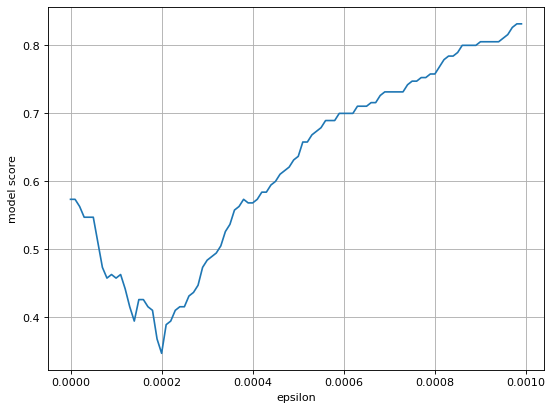

In [124]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
epsilons=np.arange(start=0.0,stop=10e-4, step=10e-6)
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comp_id, True))
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

In [122]:
10e-4

0.001

In [110]:
X.shape

(950, 14)

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty

Epsilon =  0.0
Coefficient impact:
order_inbalance   0.1934838571992612
vwaps_buy   -0.4892884950806844
vwaps_sell   -0.03795973575991137
s2f_impact_buy   0.49083245851456964
s2f_impact_sell   -0.18494658100372907
trading_volumes   0.1075184878751063
price_volatiliti

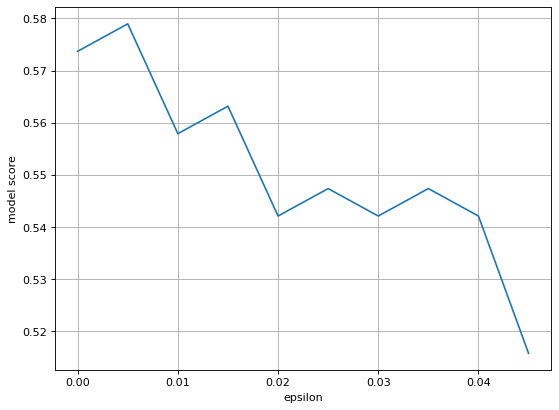

In [115]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'pri
]
X_raw,y_raw=get_X_y_raw(comp_id, interval, time_to_skip, names, y_name='true_price', check_change=True)
X, y=get_X_y_averaged(X_raw,y_raw, time_back)
epsilons=np.arange(0.0,0.05, 0.005)
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, True))
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

In [111]:
X_raw.shape

(14, 10, 96)

# find best epsilon

In [199]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
epsilons=np.arange(start=0.0,stop=2*10e-7, step=10e-8)
comp_eps=np.zeros((len(list_of_companies_number), len(epsilons)))

In [200]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))
       

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
1
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of i

26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
12
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916

32.5% of intervals were SELL empty
26.041666666666668% of intervals were BUY empty
23
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were 

25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
25.625% of intervals were SELL empty
23.697916666666668% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
26.614583333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
35
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of interval

20.9375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
46
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
47
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of int

24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
58
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty

22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
22.760416666666668% of intervals were SELL empty
19.322916666666668% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
29.270833333333332% of intervals were SELL empty
30.46875% of intervals were BUY empty
69
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of inter

24.947916666666668% of intervals were SELL empty
25.208333333333332% of intervals were BUY empty
80
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
81
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL e

25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
92
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty


In [140]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X_raw,y_raw=get_X_y_raw(comp_id, interval, time_to_skip, names, y_name='true_price', check_change=True)
    X,y=get_X_y_averaged(X_raw, y_raw, time_back)
    for eps in range(epsilons.size):
        comp_eps[comp_id,eps]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilons[eps], comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
1
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of i

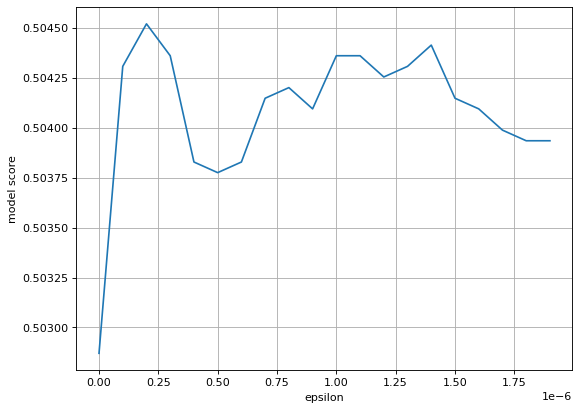

In [201]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()

plt.plot(epsilons,np.sum(comp_eps, axis=0)/99)   ###NAJLEPIEJ DZIAŁA dla eps=0 ?????? ofc przy tych konkretnych parametrach interval, timeback itd

In [103]:
#best epsilon ->( 10e-7 or 2*10e-7 )* average comp price


In [133]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=10e-7
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
print(average_comp_price[comp_id])
X,y=get_X_y_classic(comp_id, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)

Xy=np.empty(shape=(X.shape[0], X.shape[1]+1))
Xy[:,:14]=X
Xy[:,14]=y
Xy=np.random.permutation(Xy)
X=Xy[:,:14]
y=Xy[:,14]
test_decision_tree_classic(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True)

851.5588014785882
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
Coefficient impact:
order_inbalance   0.1443913263712216
vwaps_buy   0.02456883894370245
vwaps_sell   0.05234409206910518
s2f_impact_buy   0.11145980569044744
s2f_impact_sell   0.017901839533718093
trading_volumes   0.12493285938960391
price_volatili

0.4842105263157895

In [111]:
X.shape

(950, 14)

# check most important features 

In [147]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

order_inbalance 0.17948253423849625
vwaps_buy 0.25330720242388016
vwaps_sell 0.2281234758162655
s2f_impact_buy 0.24785313632599992
s2f_impact_sell 0.23027961959971138
trading_volumes 0.31059454666497827
price_volatilities 0.3049896633872235
vwaps_order_sizes_buy 0.2728112442519734
vwaps_order_sizes_sell 0.3127321223816935
s2f_order_sizes_buy 0.3016224815010161
s2f_order_sizes_sell 0.2637382035485666
next_trade_time 0.2433838086883257
next_trade_size 0.30119450008583337
next_trade_price 0.21099356033166106


# try with different features

In [159]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=10e-7
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [130]:
X,y=get_X_y_classic(0, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
print(X.shape)
print(np.delete(X, 0, 0).shape)

29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
(950, 14)
(949, 14)


In [161]:
comps=[0, 3, 21, 37,54, 69]
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
    X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    scores[c,0]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=test_logistic_regr_classic(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
Coefficient impact:
order_inbalance   0.5791462796603357
vwaps_buy   -0.38733874200638113
vwaps_sell   -0.5039138248645267
s2f_impact_buy   0.2241295332566658
s2f_impact_sell   -0.20541492557895502
trading_volumes   -0.26118804194726475
price_volatilities   -0.096

Coefficient impact:
trading_volumes   0.5639164879878967
price_volatilities   -0.37303161233404686
vwaps_order_sizes_buy   -0.5642802414831057
vwaps_order_sizes_sell   0.24682253752129893
s2f_order_sizes_buy   -0.25725159146428317
s2f_order_sizes_sell   -0.10051332191383328
next_trade_time   -0.30256871023550214
next_trade_size   0.12957007959436095
next_trade_price   -0.5752374938017285
order_inbalance   0.3114600064788237
vwaps_buy   0.0988161113240661
vwaps_sell   -0.0184934388289551
s2f_impact_buy   -0.10898876745889388
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   0.5790676163420265
vwaps_order_sizes_buy   -0.39123727223360083
vwaps_order_sizes_sell   -0.5044510976324287
s2f_order_sizes_buy   0.21978351429525902
s2f_order_sizes_sell   -0.2055013628253119
next_trade_time   -0.0976334768049109
next_trade_size   -0.30427447939437646
next_trade_price   0.12241726819084094
order_inbalance   -0.5768436469756266
vwaps_buy   0.4118116393977332
vwaps_sell   0.09171361

Coefficient impact:
next_trade_time   0.1912231728669265
next_trade_size   -0.4872395119091805
next_trade_price   -0.03463289126023983
order_inbalance   0.49182157285174727
vwaps_buy   -0.14753527964929658
vwaps_sell   0.10935789817017967
s2f_impact_buy   0.4604717635002096
s2f_impact_sell   0.39182918497868996
trading_volumes   0.22872768284017533
price_volatilities   -0.47618321210739883
vwaps_order_sizes_buy   -0.38730370786842977
vwaps_order_sizes_sell   0.29892028004178767
s2f_order_sizes_buy   0.08342154378521649
skipped  s2f_order_sizes_sell 

Coefficient impact:
next_trade_size   0.1957582689562104
next_trade_price   -0.5182614193123045
order_inbalance   -0.08269840337562823
vwaps_buy   0.48193019224072997
vwaps_sell   -0.1868605588502276
s2f_impact_buy   0.12751316896362302
s2f_impact_sell   0.48152785122479447
trading_volumes   0.39328195431290836
price_volatilities   0.1850983171966297
vwaps_order_sizes_buy   -0.4551291643229289
vwaps_order_sizes_sell   0.08332146958171198
s

price_volatilities   -0.11861900165480298
vwaps_order_sizes_buy   -0.13413015993544766
vwaps_order_sizes_sell   -0.04621052079381295
s2f_order_sizes_buy   -0.344480587649588
s2f_order_sizes_sell   -0.6072553595915049
next_trade_time   0.40676911982454267
next_trade_size   -0.3262255625119896
skipped  next_trade_price 

Coefficient impact:
vwaps_buy   -0.9165664768315677
vwaps_sell   -0.157954313607329
s2f_impact_buy   0.275757059352726
s2f_impact_sell   0.18680163877161615
trading_volumes   -0.0840654584628702
price_volatilities   -0.1820764312795747
vwaps_order_sizes_buy   0.12586196362170216
vwaps_order_sizes_sell   0.041400731493017165
s2f_order_sizes_buy   -0.8685734880831198
s2f_order_sizes_sell   -0.046194165600822
next_trade_time   0.30694895310795567
next_trade_size   0.419189523851129
next_trade_price   -0.04596510691302227
skipped  order_inbalance 

Coefficient impact:
vwaps_sell   -0.04676827069667728
s2f_impact_buy   0.08237146042465168
s2f_impact_sell   0.14534982102040714

Coefficient impact:
s2f_impact_sell   -0.1119531873183754
trading_volumes   0.32080764371540443
price_volatilities   0.7640332090692422
vwaps_order_sizes_buy   0.05263514303237343
vwaps_order_sizes_sell   0.44135120830666563
s2f_order_sizes_buy   -0.34936509798671217
s2f_order_sizes_sell   0.8120834172638098
next_trade_time   0.6445539596702028
next_trade_size   0.8809089851510566
next_trade_price   0.1594918841607805
order_inbalance   0.21063910819641343
vwaps_buy   0.4895557927452163
vwaps_sell   0.27519943861277396
skipped  s2f_impact_buy 

Coefficient impact:
trading_volumes   -0.08558324282948879
price_volatilities   0.2994734700651517
vwaps_order_sizes_buy   0.7986731682961936
vwaps_order_sizes_sell   0.5150519848584922
s2f_order_sizes_buy   0.44111265443969166
s2f_order_sizes_sell   -0.325865434562511
next_trade_time   0.8853255007763605
next_trade_size   0.613766418420374
next_trade_price   0.400357286959579
order_inbalance   0.2145304119630667
vwaps_buy   0.19931937152344884
v

vwaps_order_sizes_sell   -0.11769668023211073
s2f_order_sizes_buy   -0.4646127593478694
s2f_order_sizes_sell   0.0019954329394821003
next_trade_time   -0.7155736358554526
next_trade_size   -0.26226403929683034
next_trade_price   0.17239122261867748
order_inbalance   -0.32172338447493787
vwaps_buy   0.1104167356594667
vwaps_sell   0.18460822837136082
s2f_impact_buy   0.44346873178175655
skipped  s2f_impact_sell 

Coefficient impact:
price_volatilities   -0.15011174378285305
vwaps_order_sizes_buy   0.5071000939440784
vwaps_order_sizes_sell   -0.29279416751845927
s2f_order_sizes_buy   -0.10926261505288334
s2f_order_sizes_sell   0.018181051045173043
next_trade_time   -0.004049293576943358
next_trade_size   -0.7251318566938225
next_trade_price   -0.26110088363613965
order_inbalance   0.16487285705730073
vwaps_buy   -0.3995855705431235
vwaps_sell   0.1146625414229185
s2f_impact_buy   0.18030977693240938
s2f_impact_sell   0.46025634914791136
skipped  trading_volumes 

Coefficient impact:
vwap

In [160]:
X,y=get_X_y_classic(3, interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
test_logistic_regr_classic(X, 
                                               np.copy(y),split_percent, 
                                               epsilon, comps[c], True, local_names=names)

29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
17.552083333333332% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
30.729166666666668% of intervals were SELL empty
19.6875% of intervals were BUY empty
Coefficient impact:
order_inbalance   0.1934838571992612
vwaps_buy   -0.4892884950806844
vwaps_sell   -0.03795973575991137
s2f_impact_buy   0.49083245851456964
s2f_impact_sell   -0.18494658100372907
trading_volumes   0.1075184878751063
price_volatilities   0.460375372

0.5736842105263158

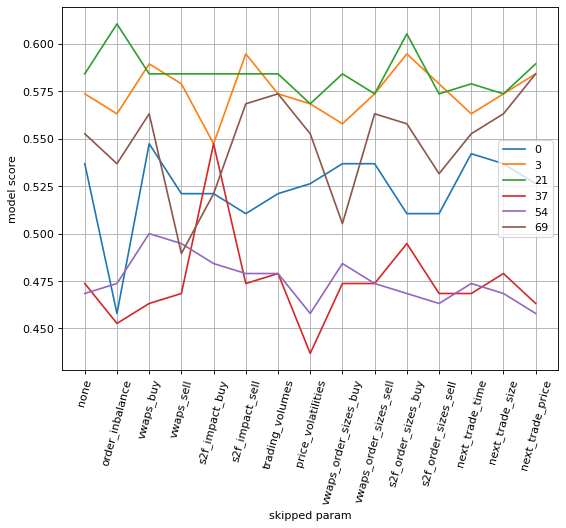

In [162]:
### FEATURE DROPPED ON X AXIS

figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
for c in range(len(comps)):
    plt.plot( scores[c])
plt.legend(comps)


In [167]:

names

['order_inbalance',
 'vwaps_buy',
 'vwaps_sell',
 's2f_impact_buy',
 's2f_impact_sell',
 'trading_volumes',
 'price_volatilities',
 'vwaps_order_sizes_buy',
 'vwaps_order_sizes_sell',
 's2f_order_sizes_buy',
 's2f_order_sizes_sell',
 'next_trade_time',
 'next_trade_size',
 'next_trade_price']

In [166]:
comps=[0, 3, 21, 30,50, 89]
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores_tree=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
    X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    scores_tree[c,0]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores_tree[c,i]=test_decision_tree_classic(np.delete(comps_X[c], i-1, 1), np.copy(comps_y[c]),split_percent, epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('\nskipped ', name)
        #AFTER SCALING

29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
Coefficient impact:
order_inbalance   0.5791462796603357
vwaps_buy   -0.38733874200638113
vwaps_sell   -0.5039138248645267
s2f_impact_buy   0.2241295332566658
s2f_impact_sell   -0.20541492557895502
trading_volumes   -0.26118804194726475
price_volatilities   -0.096

s2f_order_sizes_sell   0.05752464492318554
next_trade_time   0.060826438111124044
next_trade_size   0.018556130853065737
next_trade_price   0.1311572458452423
order_inbalance   0.020223586032161213
vwaps_buy   0.04053951204656129
vwaps_sell   0.07072524362190513
s2f_impact_buy   0.034742809342729344
s2f_impact_sell   0.11457532789562669
trading_volumes   0.08691918441945612
price_volatilities   0.1260366519155534

skipped  vwaps_order_sizes_buy
Coefficient impact:
s2f_order_sizes_buy   0.1788198212776568
s2f_order_sizes_sell   0.060352102910669836
next_trade_time   0.06255231609417065
next_trade_size   0.041527633867132846
next_trade_price   0.02510591227909994
order_inbalance   0.16132247717479983
vwaps_buy   0.009015777002440384
vwaps_sell   0.06735505380022246
s2f_impact_buy   0.02867026946881158
s2f_impact_sell   0.04101406898776943
trading_volumes   0.10792752483404287
price_volatilities   0.10468036278555384
vwaps_order_sizes_buy   0.11165667951762973

skipped  vwaps_order_sizes_


skipped  order_inbalance
Coefficient impact:
vwaps_sell   0.1280577698149749
s2f_impact_buy   0.03550330435208271
s2f_impact_sell   0.04001014815134223
trading_volumes   0.056887723570583845
price_volatilities   0.11677017013907671
vwaps_order_sizes_buy   0.010851429061731874
vwaps_order_sizes_sell   0.0679622863330257
s2f_order_sizes_buy   0.07537476985603486
s2f_order_sizes_sell   0.03905272048843176
next_trade_time   0.029071492640580062
next_trade_size   0.08270375037748669
next_trade_price   0.13113576618457948
order_inbalance   0.186618669030069

skipped  vwaps_buy
Coefficient impact:
s2f_impact_buy   0.1458214171169175
s2f_impact_sell   0.06383786829536009
trading_volumes   0.016560234627785334
price_volatilities   0.07234192864892465
vwaps_order_sizes_buy   0.10576215195154279
vwaps_order_sizes_sell   0.0234717053335511
s2f_order_sizes_buy   0.032837668573402146
s2f_order_sizes_sell   0.04466151036991973
next_trade_time   0.013685984427004957
next_trade_size   0.03981951457920

Coefficient impact:
s2f_order_sizes_buy   0.18274798075466195
s2f_order_sizes_sell   0.06493444738971431
next_trade_time   0.08280099158191921
next_trade_size   0.042615365644955494
next_trade_price   0.039369349871245934
order_inbalance   0.11669032485118219
vwaps_buy   0.020040413829392516
vwaps_sell   0.019434957425946593
s2f_impact_buy   0.04123381634482022
s2f_impact_sell   0.08361292196979676
trading_volumes   0.11726388957919989
price_volatilities   0.11766620498562211
vwaps_order_sizes_buy   0.07158933577154278

skipped  vwaps_order_sizes_sell
Coefficient impact:
s2f_order_sizes_sell   0.09391554541978814
next_trade_time   0.05640269350175888
next_trade_size   0.03835430241794987
next_trade_price   0.045535045650677675
order_inbalance   0.06505881122069425
vwaps_buy   0.14656366157382755
vwaps_sell   0.017684706154140504
s2f_impact_buy   0.06003749754470433
s2f_impact_sell   0.06113180985393192
trading_volumes   0.04084332243992399
price_volatilities   0.1213574309626478
vwaps_

s2f_impact_sell   0.04473289390358786
trading_volumes   0.04440174333034701
price_volatilities   0.0686781771352203
vwaps_order_sizes_buy   0.11561122427044616
vwaps_order_sizes_sell   0.02083800592017863
s2f_order_sizes_buy   0.06181201472183831
s2f_order_sizes_sell   0.04078235698717886
next_trade_time   0.06308376492321806
next_trade_size   0.030352635779517002
next_trade_price   0.13790388348675306
order_inbalance   0.12795398171890865
vwaps_buy   0.11945671455034715

skipped  vwaps_sell
Coefficient impact:
s2f_impact_sell   0.13848103186853392
trading_volumes   0.049093394167859045
price_volatilities   0.04913044083353717
vwaps_order_sizes_buy   0.06563924010371507
vwaps_order_sizes_sell   0.14445607737990235
s2f_order_sizes_buy   0.011389373831631317
s2f_order_sizes_sell   0.06966944127697665
next_trade_time   0.037224501124994674
next_trade_size   0.07294999500890022
next_trade_price   0.0363493795836895
order_inbalance   0.10298209240625018
vwaps_buy   0.11829622076652475
vwaps

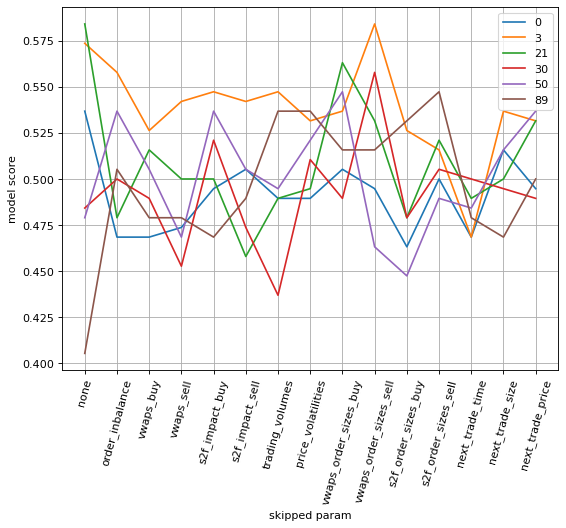

In [167]:
### FEATURE DROPPED ON X AXIS

figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
for c in range(len(comps)):
    plt.plot( scores_tree[c])
plt.legend(comps)


In [165]:
scores

array([[0.53684211, 0.45789474, 0.54736842, 0.52105263, 0.52105263,
        0.51052632, 0.52105263, 0.52631579, 0.53684211, 0.53684211,
        0.51052632, 0.51052632, 0.54210526, 0.53684211, 0.52631579],
       [0.57368421, 0.56315789, 0.58947368, 0.57894737, 0.54736842,
        0.59473684, 0.57368421, 0.56842105, 0.55789474, 0.57368421,
        0.59473684, 0.57894737, 0.56315789, 0.57368421, 0.58421053],
       [0.58421053, 0.61052632, 0.58421053, 0.58421053, 0.58421053,
        0.58421053, 0.58421053, 0.56842105, 0.58421053, 0.57368421,
        0.60526316, 0.57368421, 0.57894737, 0.57368421, 0.58947368],
       [0.48421053, 0.45263158, 0.46315789, 0.46842105, 0.54736842,
        0.47368421, 0.47894737, 0.43684211, 0.47368421, 0.47368421,
        0.49473684, 0.46842105, 0.46842105, 0.47894737, 0.46315789],
       [0.47894737, 0.47368421, 0.5       , 0.49473684, 0.48421053,
        0.47894737, 0.47894737, 0.45789474, 0.48421053, 0.47368421,
        0.46842105, 0.46315789, 0.47368421, 

In [177]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=0.005
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    #'next_trade_time',
    #'next_trade_size',
    #'next_trade_price',
    #'price change'
      ]
X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, use_scaling=False, local_names=names)

22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
22.708333333333332% of intervals were SELL empty
21.145833333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
24.739583333333332% of intervals were BUY empty
Coefficient impact:
order_inbalance   -1.0142233940122694e-08
vwaps_buy   1.5403847571112574e-07
vwaps_sell   -6.29343797654288e-08
s2f_impact_buy   1.5136884182688243e-08
s2f_impact_sell   1.421261201058333e-09
trading_volu

0.4789473684210526

# FIND BEST TIME_BACK

In [170]:
interval=5
time_to_skip=30
epsilon=10e-7
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
time_backs=np.array([1,3,5,10,20])
comp_backs=np.zeros((len(list_of_companies_number), len(time_backs)))

In [179]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_raw,y_raw=get_X_y_raw(comp_id, interval, time_to_skip, names, y_name='true_price', check_change=True)
    for tb in range(time_backs.size):
        X,y=get_X_y_averaged(X_raw, y_raw, time_backs[tb])
        comp_backs[comp_id,tb]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
1
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
22.34375% of intervals were SELL empty
23.4375% of intervals were BUY empty
26.770833333333332% of intervals were SELL empty
28.75% of intervals were BUY empty
26.770833333333332% of i

23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
23.75% of intervals were SELL empty
20.3125% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
26.354166666666668% of intervals were SELL empty
23.489583333333332% of intervals were BUY empty
12
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
24.21875% of intervals were SELL empty
20.15625% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916666666668% of intervals were BUY empty
31.770833333333332% of intervals were SELL empty
24.322916

23
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
24.322916666666668% of intervals were SELL empty
21.666666666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
25.833333333333332% of intervals were SELL empty
23.229166666666668% of intervals were BUY empty
24
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
25.104166666666668% of intervals were SELL empty
18.177083333333332% of intervals were BUY empty
26.979166666666668% of i

35
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
17.1875% of intervals were SELL empty
24.791666666666668% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
19.583333333333332% of intervals were SELL empty
26.5625% of intervals were BUY empty
36
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
20.208333333333332% of intervals were SELL empty
23.645833333333332% of intervals were BUY empty
30.416666666666668% of intervals were SELL empty
34.947916666666664% of intervals were BUY empty
30.416666666666

27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
16.666666666666668% of intervals were SELL empty
26.927083333333332% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
27.96875% of intervals were SELL empty
34.114583333333336% of intervals were BUY empty
47
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
18.385416666666668% of intervals were SELL empty
25.885416666666668% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
17.604166666666668% of intervals were SELL empty
25.36458

24.53125% of intervals were SELL empty
15.364583333333334% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
47.8125% of intervals were SELL empty
46.145833333333336% of intervals were BUY empty
58
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
23.020833333333332% of intervals were SELL empty
19.010416666666668% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
31.5625% of intervals were SELL empty
31.5625% of intervals were BUY empty
59
19.010416666666668% of intervals were SELL empt

69
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
15.833333333333334% of intervals were SELL empty
27.708333333333332% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
21.770833333333332% of intervals were SELL empty
32.34375% of intervals were BUY empty
70
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
20.572916666666668% of intervals were SELL empty
22.96875% of intervals were BUY empty
30.052083333333332% of intervals were SELL empty
35.0% of intervals were BUY empty
3

28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
25.572916666666668% of intervals were SELL empty
19.791666666666668% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
28.229166666666668% of intervals were SELL empty
21.927083333333332% of intervals were BUY empty
81
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
24.21875% of intervals were SELL empty
34.583333333333336% of intervals were BUY empty
14.84375% of intervals were SELL empty
27.760416666666668% of inter

25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
25.520833333333332% of intervals were SELL empty
19.583333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
34.583333333333336% of intervals were SELL empty
31.458333333333332% of intervals were BUY empty
92
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
16.5625% of intervals were SELL empty
25.364583333333332% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% of intervals were BUY empty
24.53125% of intervals were SELL empty
30.0% o

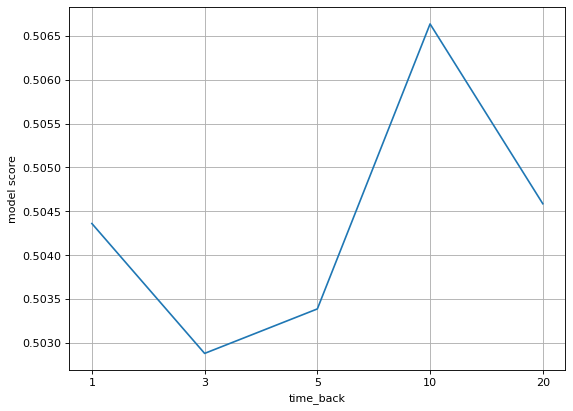

In [180]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='time_back', ylabel='model score')
plt.xticks(np.arange(len(time_backs)), time_backs, rotation='0')
plt.grid()

plt.plot(np.sum(comp_backs, axis=0)/99)

# FIND BEST INTERVAL

In [190]:
time_back=1
time_to_skip=30
epsilon=10e-7
split_percent = 0.8
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
intervals=[1,3,5,10,20,60]  ##Timedelta does not accept np.int32 which is default for np array of ints, therefore use normal list
comp_inters=np.zeros((len(list_of_companies_number), len(intervals)))

In [192]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//20):
    print(comp_id)
    for inter in range(len(intervals)):
        print('interval ', intervals[inter])
        X,y=get_X_y_classic(comps[c], intervals[inter], time_to_skip, time_back, names, y_name='true_price', check_change=True) 
#        X_raw,y_raw=get_X_y_raw(comp_id, intervals[inter], time_to_skip, names, y_name='true_price', check_change=True)
 #       X,y=get_X_y_averaged(X_raw, y_raw, time_back)
        comp_inters[comp_id,inter]=test_logistic_regr_classic(X, np.copy(y),split_percent, epsilon, comp_id, True, track_params=True)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
interval  1
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
interval  3
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
24.78125% of inter

32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.15625% of intervals were SELL empty
33.3125% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
32.34375% of intervals were SELL empty
33.520833333333336% of intervals were BUY empty
interval  3
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
24.78125% of intervals were SELL empty
23.875% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
26.09375% of intervals were SELL empty
25.34375% of intervals were BUY empty
24.78125% of intervals were SELL

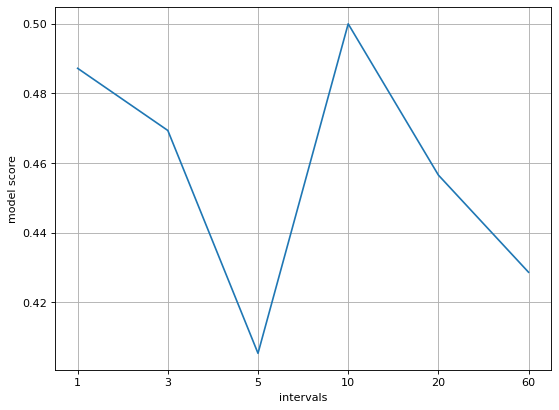

In [197]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='intervals', ylabel='model score')
plt.xticks(np.arange(len(intervals)), intervals, rotation='0')
plt.grid()

plt.plot(np.sum(comp_inters, axis=0)/4)

# find best threshold for price swing

In [189]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=5
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.geomspace(1e-3, 1e-10, num=8)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds)))

In [190]:
thresholds

array([1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07, 1.e-08, 1.e-09, 1.e-10])

In [191]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_min', swing_interval=60, threshold=thresholds[th])
#        X_raw,y_raw=get_X_y_raw(comp_id, intervals[inter], time_to_skip, names, y_name='true_price', check_change=True)
 #       X,y=get_X_y_averaged(X_raw, y_raw, time_back)
        print(y.shape)
        comp_ths[comp_id,th]=test_logistic_regr_classic(X, y,split_percent, check_up_down=False, track_params=False)
print("calculations took: {} seconds".format(  time.time()-time_start))

0
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.21875% of intervals were SELL empty
19.114583333333332% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
29.635416666666668% of intervals were SELL empty
19.479166666666668% of intervals were BUY empty
threshold  0.001
(950, 14)
(950,)
Coefficient impact:
order_inbalance   -0.09397155748146485
vwaps_buy   0.545381899615453
vwaps_sell   -0.18162330706471733
s2f_impact_buy   0.4618257244161646
s2f_impact_sell   0.742659810455733
trading_volumes   -0.317314774030

(950,)
Coefficient impact:
order_inbalance   -0.2308732376580356
vwaps_buy   0.0411628098206096
vwaps_sell   -0.08028226956583592
s2f_impact_buy   0.6041844267294867
s2f_impact_sell   -0.05684547601505785
trading_volumes   -0.3796877827310855
price_volatilities   0.33277650155708305
vwaps_order_sizes_buy   -0.9454774380041566
vwaps_order_sizes_sell   0.21248154720874265
s2f_order_sizes_buy   -0.1796081783923333
s2f_order_sizes_sell   -0.11004778434313742
next_trade_time   -0.2940876017353084
next_trade_size   -0.34162857089629994
next_trade_price   0.08622501982094978
threshold  1e-09
(950, 14)
(950,)
Coefficient impact:
order_inbalance   -0.2308732376580356
vwaps_buy   0.0411628098206096
vwaps_sell   -0.08028226956583592
s2f_impact_buy   0.6041844267294867
s2f_impact_sell   -0.05684547601505785
trading_volumes   -0.3796877827310855
price_volatilities   0.33277650155708305
vwaps_order_sizes_buy   -0.9454774380041566
vwaps_order_sizes_sell   0.21248154720874265
s2f_order_sizes_buy   -0.

Coefficient impact:
order_inbalance   0.0343382191680341
vwaps_buy   0.3188928648779921
vwaps_sell   -0.7545498209823384
s2f_impact_buy   -0.6182781032352394
s2f_impact_sell   0.5242220816316951
trading_volumes   -0.4320616862648515
price_volatilities   0.3775851906840265
vwaps_order_sizes_buy   -0.22800051517176145
vwaps_order_sizes_sell   -0.02699016341032575
s2f_order_sizes_buy   -0.279288269327836
s2f_order_sizes_sell   -0.2648381714650471
next_trade_time   1.370766731782928
next_trade_size   0.14795342357806424
next_trade_price   0.6228424055037456
threshold  1e-10
(950, 14)
(950,)
Coefficient impact:
order_inbalance   0.0343382191680341
vwaps_buy   0.3188928648779921
vwaps_sell   -0.7545498209823384
s2f_impact_buy   -0.6182781032352394
s2f_impact_sell   0.5242220816316951
trading_volumes   -0.4320616862648515
price_volatilities   0.3775851906840265
vwaps_order_sizes_buy   -0.22800051517176145
vwaps_order_sizes_sell   -0.02699016341032575
s2f_order_sizes_buy   -0.279288269327836
s

<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price


Coefficient impact:
order_inbalance   -0.7761277209560096
vwaps_buy   0.6087273385368798
vwaps_sell   0.20755261340625095
s2f_impact_buy   -0.9414060760726214
s2f_impact_sell   -0.02665238431891953
trading_volumes   -1.3716722409018216
price_volatilities   -0.12082737680547807
vwaps_order_sizes_buy   -0.5130893025599348
vwaps_order_sizes_sell   -0.36995870279428894
s2f_order_sizes_buy   0.2804691728165097
s2f_order_sizes_sell   0.4997014434423992
next_trade_time   -0.36066479080346703
next_trade_size   -0.08916765515833948
next_trade_price   -0.31073769742663165
threshold  1e-06
(950, 14)
(950,)
Coefficient impact:
order_inbalance   -0.8009127159515631
vwaps_buy   0.48380396379683216
vwaps_sell   0.06626392760666616
s2f_impact_buy   -0.9891235018029508
s2f_impact_sell   -0.07623543659377895
trading_volumes   -1.3944490626439112
price_volatilities   -0.11190760517310964
vwaps_order_sizes_buy   -0.5340194989001227
vwaps_order_sizes_sell   -0.391203378019807
s2f_order_sizes_buy   0.288697

<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price



vwaps_sell   0.06626392760666616
s2f_impact_buy   -0.9891235018029508
s2f_impact_sell   -0.07623543659377895
trading_volumes   -1.3944490626439112
price_volatilities   -0.11190760517310964
vwaps_order_sizes_buy   -0.5340194989001227
vwaps_order_sizes_sell   -0.391203378019807
s2f_order_sizes_buy   0.2886979766213365
s2f_order_sizes_sell   0.5099161434564877
next_trade_time   -0.3203490472607352
next_trade_size   -0.09997963474480713
next_trade_price   -0.1632090924364498
threshold  1e-08
(950, 14)
(950,)
Coefficient impact:
order_inbalance   -0.8009127159515631
vwaps_buy   0.48380396379683216
vwaps_sell   0.06626392760666616
s2f_impact_buy   -0.9891235018029508
s2f_impact_sell   -0.07623543659377895
trading_volumes   -1.3944490626439112
price_volatilities   -0.11190760517310964
vwaps_order_sizes_buy   -0.5340194989001227
vwaps_order_sizes_sell   -0.391203378019807
s2f_order_sizes_buy   0.2886979766213365
s2f_order_sizes_sell   0.5099161434564877
next_trade_time   -0.3203490472607352
n

<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price
<ipython-input-187-feb43cf61c11>:22: RuntimeWarning: invalid value encountered in double_scalars
  if (min_val-true_prices[i,j])/true_prices[i,j]<=-threshold: # price swing >= than threshold % of price



s2f_impact_buy   -0.9891235018029508
s2f_impact_sell   -0.07623543659377895
trading_volumes   -1.3944490626439112
price_volatilities   -0.11190760517310964
vwaps_order_sizes_buy   -0.5340194989001227
vwaps_order_sizes_sell   -0.391203378019807
s2f_order_sizes_buy   0.2886979766213365
s2f_order_sizes_sell   0.5099161434564877
next_trade_time   -0.3203490472607352
next_trade_size   -0.09997963474480713
next_trade_price   -0.1632090924364498
threshold  1e-10
(950, 14)
(950,)
Coefficient impact:
order_inbalance   -0.8009127159515631
vwaps_buy   0.48380396379683216
vwaps_sell   0.06626392760666616
s2f_impact_buy   -0.9891235018029508
s2f_impact_sell   -0.07623543659377895
trading_volumes   -1.3944490626439112
price_volatilities   -0.11190760517310964
vwaps_order_sizes_buy   -0.5340194989001227
vwaps_order_sizes_sell   -0.391203378019807
s2f_order_sizes_buy   0.2886979766213365
s2f_order_sizes_sell   0.5099161434564877
next_trade_time   -0.3203490472607352
next_trade_size   -0.0999796347448

(950,)
Coefficient impact:
order_inbalance   0.5067258408974518
vwaps_buy   0.5295317595279206
vwaps_sell   -0.7286577978480696
s2f_impact_buy   0.12523508963382132
s2f_impact_sell   0.4084793902616649
trading_volumes   -0.2814085751785144
price_volatilities   0.034697064536209576
vwaps_order_sizes_buy   -0.5988614265862796
vwaps_order_sizes_sell   0.1420700627410347
s2f_order_sizes_buy   0.5836767422713752
s2f_order_sizes_sell   -0.05672392874090992
next_trade_time   0.3130711964866349
next_trade_size   0.4345170034757712
next_trade_price   0.1847154702810847
threshold  1e-06
(950, 14)
(950,)
Coefficient impact:
order_inbalance   0.5289374134539644
vwaps_buy   0.57106036878381
vwaps_sell   -0.7326544846439538
s2f_impact_buy   0.12197731210649013
s2f_impact_sell   0.39064058000036556
trading_volumes   -0.2983107353550991
price_volatilities   0.042394314111181594
vwaps_order_sizes_buy   -0.606798891621082
vwaps_order_sizes_sell   0.13959508496020934
s2f_order_sizes_buy   0.5640190275080

21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
21.354166666666668% of intervals were SELL empty
24.427083333333332% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
30.625% of intervals were SELL empty
31.041666666666668% of intervals were BUY empty
threshold  0.001
(950, 14)
(950,)
Coefficient impact:
order_inbalance   0.5596855605262574
vwaps_buy   0.7862297102138831
vwaps_sell   -0.5669137509091409
s2f_impact_buy   0.9369750537661806
s2f_impact_sell   0.6899007606956519
trading_volumes   -0.7093610557030596
price_

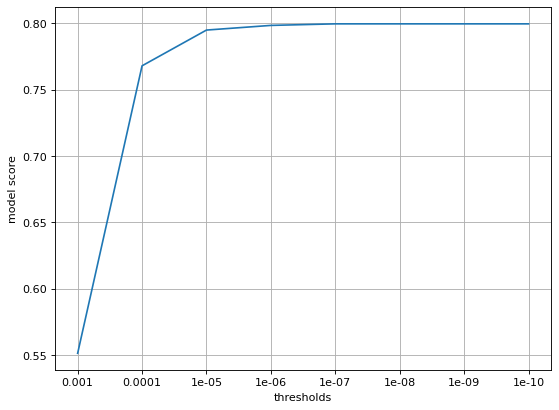

In [192]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='0')
plt.grid()

plt.plot(np.sum(comp_ths, axis=0)/9)

# XGBOOST

In [115]:
def test_xgb(X, y, split_percent, epsilon, use_scaling=False, check_up_down=True):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon)#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), xgb.XGBRegressor()).fit(X[:split], y[:split])
      #  print(clf.named_steps)
      #  print("Coefficient impact:")
      #  for i in range(len(names)):
      #      print(names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = xgb.XGBRegressor().fit(X[:split], y[:split])
      #  print("Coefficient impact:")
       # for i in range(len(names)):
        #    print(names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    print("mse: ", mse(y[split:], y_predicted))
    print("xgboost score: ", clf.score(X[split:], y[split:]))
    return clf.score(X[split:], y[split:])    
  #  split=int(y.size*split_percent)
   # dtrain = xgb.DMatrix(X[:split], y[:split])
    #param=[]
    #num_round=10
    #bst = xgb.train(param, dtrain)
    #y_predicted=bst.predict(X[split:])
    


Epsilon =  0.0
mse:  1.3137035605457383
logistic regr score:  -0.33155600111470007

Epsilon =  0.005
mse:  1.2005510544519653
logistic regr score:  -0.2249482226538524

Epsilon =  0.01
mse:  1.1907677994721921
logistic regr score:  -0.2384890823978263

Epsilon =  0.015
mse:  1.1225836586473874
logistic regr score:  -0.17546322302966377

Epsilon =  0.02
mse:  1.158554612254488
logistic regr score:  -0.23739116870967525

Epsilon =  0.025
mse:  1.1609732731923983
logistic regr score:  -0.239974413084189

Epsilon =  0.03
mse:  1.1116139528645954
logistic regr score:  -0.2062058883168083

Epsilon =  0.035
mse:  1.190647936729637
logistic regr score:  -0.2919652083302742

Epsilon =  0.04
mse:  1.1335101031014205
logistic regr score:  -0.23849015502304138

Epsilon =  0.045
mse:  1.15066724555505
logistic regr score:  -0.2868366655680703

Epsilon =  0.05
mse:  1.090772219438975
logistic regr score:  -0.22558676341457873

Epsilon =  0.055
mse:  1.086226269319028
logistic regr score:  -0.232292

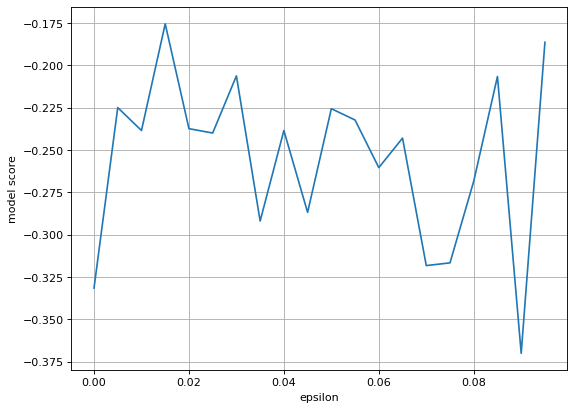

In [114]:
scores=[]
for epsilon in epsilons:
    print('\nEpsilon = ',epsilon)
    scores.append(test_xgb(X, np.copy(y),split_percent, epsilon))
#AFTER SCALING
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='epsilon', ylabel='model score')
plt.grid()
plt.plot(epsilons, scores)

# Pytorch

In [197]:
import torch

In [203]:
x = torch.rand(5, 3)
print(x)

tensor([[0.6137, 0.2698, 0.4501],
        [0.0808, 0.2387, 0.1263],
        [0.5823, 0.7184, 0.0598],
        [0.2040, 0.6396, 0.4925],
        [0.6963, 0.2041, 0.5296]])


In [205]:
torch.cuda.is_available()
    

False